# CNN-Based Food Image Classification

#### Minho Song

### 1. Preparation

#### 1.1. Evaluation Metric based on business case

The Food-11 image dataset was used for the lab two assignment.<br>
This image dataset was originally collected and used to develop an android app, NutriTake, a personalized nutrition tracking app.<br><br>
The data has 16643 food images with 11 labels,11 major food catagories, such as bread, dairy, eggs, meat etc.<br>
Due to the limited computation power and the fact that my graphic card does not support tensorflow, the random extraction of 3,000 images and resizing of the data will be performed.<br><br>
The evaluation metric for this model will be F-1 score.<br>
In the case of personalized nutrition tracking model, for which the image categorization was initaill performed, it is important to correctly identifying the category of food items to reduce the risk of missing any items. In addition, it is also crucial to avoid misclassification that can cause incorrect nutritional information.<br> F-1 score will be able to balance the precision and recall scores, making sure that the model identifies correct food category for food items while minimizing the risk of misclassification.<br><br>
In other cases such as marketing, the business can identify food trends and customers' preferences using food images on SNS.<br> This model will categorize food images and help the business capture the trends or the shifting of the preferences of customers and determine marketing strategies or product development.<br> F-1 score wil also be an appropriate metric for this case.<br>
F-1 score can help find a good trade-off between precision and recall scores, and make sure that the model captures the trends based on the balanced data.<br><br>
For both business cases, recall and precision scores are important because you want the model to perform food calssification correctly and avoid misclassification.<br> You can achieve the harmony of the two by using F-1 score as the evaluation metric.


============================================================================
Dataset: Keggle, Food-11 image dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

#### 1.2. Cross-validation method

For this task, I will use nested cross validation with 80-20 traditional split and stratified k-fold cross validation.<br>
The purpose of splitting 80-20 is to reserve the 20% of the data for testing at the end of training model.<br>
Stratified k-fold is going to be used to make sure the problem of imbalance in the dataset.<br> It is highly likely that some food categories have more food items than others.<br> Stratified k-fold will help maintain the proportion of food categories in each fold, ensuring the model is well trained on data that reflects the overall distribution of the categories.<br><br>
This method will make sure that the test set is unseen until the end of training so that the model is tested on more realistic scenario where the dataset is imbalanced, not distributed proportionally and unseen.<br>
Shuffle splits randomly shuffle the dataset, which cannot guarantee the proportion of classes per each split.<br> This characteristic of shuffle split can lead to biased training and evaluation scores.<br><br>
For this classification purpose, the dataset is expected to be imbalanced and the generalization of the model is important.<br>
Therefore, stratified k-folds will be the appropriate evaluation metric.

#### 1.3 Loading data

In [3]:
# load the data
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split

# function to load the data and resize the images
def load_and_resize_image(base_folder, target_size, num):
    images, labels = [], []
    categories = os.listdir(base_folder)
    
    for category in categories:
        category_path = os.path.join(base_folder, category)
        if not os.path.isdir(category_path):
            continue
        filenames = os.listdir(category_path)
        random.shuffle(filenames)
        for filename in filenames[:num//len(categories)]:
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                img_path = os.path.join(category_path, filename) 
                img = Image.open(img_path)
                img_gray = img.convert('L')
                img_resized = img_gray.resize(target_size, Image.LANCZOS)
                img_array = np.array(img_resized)
                images.append(img_array)
                labels.append(category)
    return np.array(images), np.array(labels) 

# path to the folder where images are saved
folder_path = r"C:\Users\송민호\Desktop\College\Machine Learning in Python\Modue 2\module-2 project\archive\training"
# Set the size for resizing the images
target_size = (64,64)

# Save the numpy arrays into variables.
X, y = load_and_resize_image(folder_path, target_size, 3000)

In [4]:
print(f"Min pixel value: {X.min()}")
print(f"Max pixel value: {X.max()}")

Min pixel value: 0
Max pixel value: 255


#### 1.4 Reshape and Normalize Data

In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Normalization
X = X.astype(np.float32)/255.0 - 0.5

y = label_encoder.fit_transform(y)

In [6]:
X = X.reshape((X.shape[0],64,64,1))
img_hw = 64
print(X.shape)
print(y.shape)

(2992, 64, 64, 1)
(2992,)


In [7]:
y_pd = pd.Series(y)
NUM_CLASSES=len(y_pd.unique())
print(NUM_CLASSES)

11


In [8]:
# Split it into train / test subsets
# Outer layer of nested cross-validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, '\n', X_test.shape)

(2393, 64, 64, 1) 
 (599, 64, 64, 1)


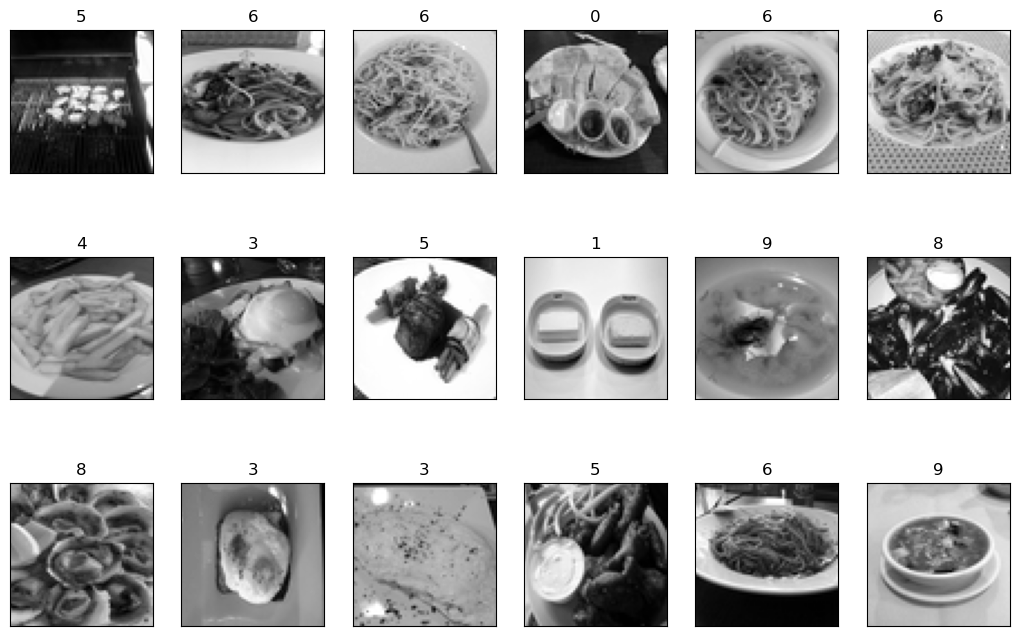

In [16]:
from matplotlib import pyplot as plt
%matplotlib inline
def visualize_image(images, labels, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    indices = list(range(len(images)))
    random.shuffle(indices)
    
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        i = indices[i]
        plt.imshow(images[i].reshape((h,w)), cmap=plt.cm.gray)
        plt.title(labels[i], size=12)
        plt.xticks(())
        plt.yticks(())

visualize_image(X_train, y_train, 64, 64)

### 2. Modeling

In [58]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, RandomRotation, RandomFlip
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Add
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras
from tensorflow.keras.regularizers import l2 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, roc_curve, auc
import seaborn as sns
from sklearn import metrics as mt

#### 2.1 Build Models

In [10]:
def build_model_base(img_hw, num_kernel, num_filter1, num_filter2):
    cnn = Sequential()
    
    # adding aumentation layers
    cnn.add(RandomFlip("horizontal"))
    cnn.add(RandomFlip('vertical'))
    cnn.add(RandomRotation(factor=(-0.2, 0.2)))
    #=====================Convolution========================
    cnn.add(Conv2D(filters=num_filter1,
                    input_shape = (img_hw,img_hw,1),
                    kernel_size=(num_kernel,num_kernel), 
                    padding='same', 
                    activation='relu')) # more compact syntax
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    cnn.add(Conv2D(filters=num_filter2,
                    kernel_size=(num_kernel,num_kernel), 
                    padding='same', 
                    activation='relu')) # more compact syntax
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    
    #===================== NN ============================
    cnn.add(Flatten())
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dropout(0.20))
    cnn.add(Dense(NUM_CLASSES, activation='softmax'))
    #=======================Compile====================================
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[F1Score(name='f1score', average='micro')])
    
    return cnn

Horizontal flip, vertical flip and rotatin in range between -0.2 and 0.2 were chosen for augmentation methods.<br>
They were chosen because the pictures of food items can be taken from any directions from above.<br> If the same food taken from different directions such as one taken from the right side and the other taken from the left, the image will be flipped representation of the same item.<br>
The pictures of food are usually taken from higher location than where the object is placed, making it easy to be taken from any direction.<br>
In order to cover all directions without making too much burden to the model, I chose random horizontal flip and random vertical flip separately so they can be applied separately, and rotation of the image could capture the pictures taken from various directions.

In [11]:
# Plot training & validation loss values
def plot_history(metrics, n_splits, epoch):
    plt.figure(figsize=(15, 20))
    for i in range(n_splits):
        plt.subplot(n_splits, 2, 2 * i + 1)
        plt.plot(metrics['loss'][i*epoch:(i+1)*epoch])
        plt.plot(metrics['val_loss'][i*epoch:(i+1)*epoch])
        plt.title(f'Fold {i+1} Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')

        # Plot training & validation accuracy values
        plt.subplot(n_splits, 2, 2 * i + 2)
        plt.plot(metrics['f1score'][i*epoch:(i+1)*epoch])
        plt.plot(metrics['val_f1score'][i*epoch:(i+1)*epoch])
        plt.title(f'Fold {i+1} Model F1 score')
        plt.ylabel('F1 score')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')    
    plt.tight_layout()
    plt.show()    

In [12]:
%matplotlib inline

labels = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat','Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    f1 = mt.f1_score(y_test,yhat,average='micro')
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(f1))

#### 2.1.1 Base Model
- Convolution - maxpooling twice
- number of features: 32 - 64
- kernel size: 3 * 3
- One dropout

Epoch 1/10


c:\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 5s - 80ms/step - f1score: 0.1416 - loss: 2.3558 - val_f1score: 0.1545 - val_loss: 2.2981
Epoch 2/10
60/60 - 3s - 47ms/step - f1score: 0.1865 - loss: 2.2468 - val_f1score: 0.2025 - val_loss: 2.1971
Epoch 3/10
60/60 - 3s - 48ms/step - f1score: 0.2388 - loss: 2.1579 - val_f1score: 0.2004 - val_loss: 2.1380
Epoch 4/10
60/60 - 3s - 47ms/step - f1score: 0.2372 - loss: 2.1224 - val_f1score: 0.2213 - val_loss: 2.1065
Epoch 5/10
60/60 - 3s - 47ms/step - f1score: 0.2685 - loss: 2.0862 - val_f1score: 0.2380 - val_loss: 2.1473
Epoch 6/10
60/60 - 3s - 47ms/step - f1score: 0.2555 - loss: 2.0846 - val_f1score: 0.2401 - val_loss: 2.1120
Epoch 7/10
60/60 - 3s - 48ms/step - f1score: 0.2748 - loss: 2.0130 - val_f1score: 0.2735 - val_loss: 2.0161
Epoch 8/10
60/60 - 3s - 48ms/step - f1score: 0.2931 - loss: 2.0017 - val_f1score: 0.2526 - val_loss: 2.0624
Epoch 9/10
60/60 - 3s - 48ms/step - f1score: 0.3088 - loss: 1.9739 - val_f1score: 0.2860 - val_loss: 2.0189
Epoch 10/10
60/60 - 3s - 47ms/step - f1

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_14 (RandomFlip)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_15 (RandomFlip)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 64, 64, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_159 (Conv2D)             │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 32, 32, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_160 (Conv2D)             │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_102               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_36 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,352,547 (24.23 MB)

 Trainable params: 2,117,515 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,235,032 (16.16 MB)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


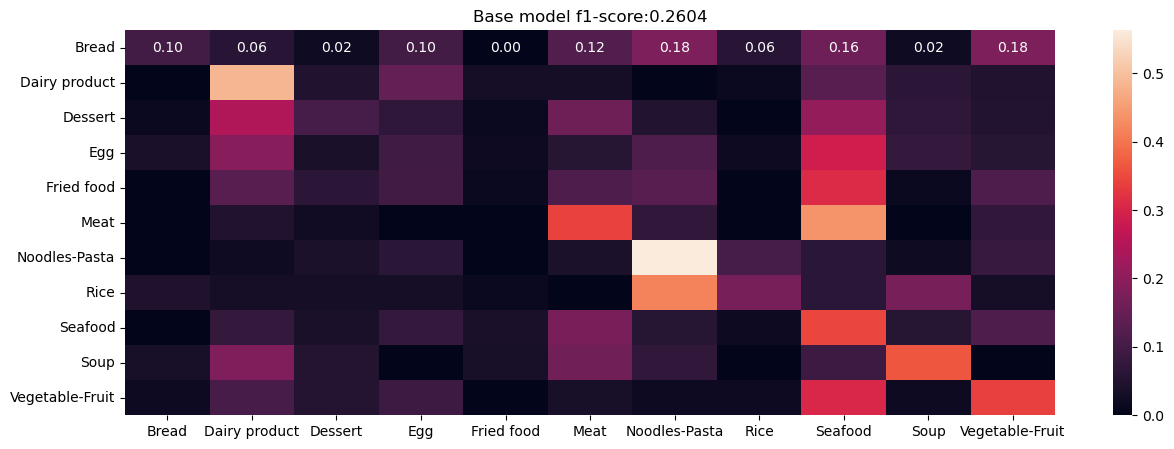

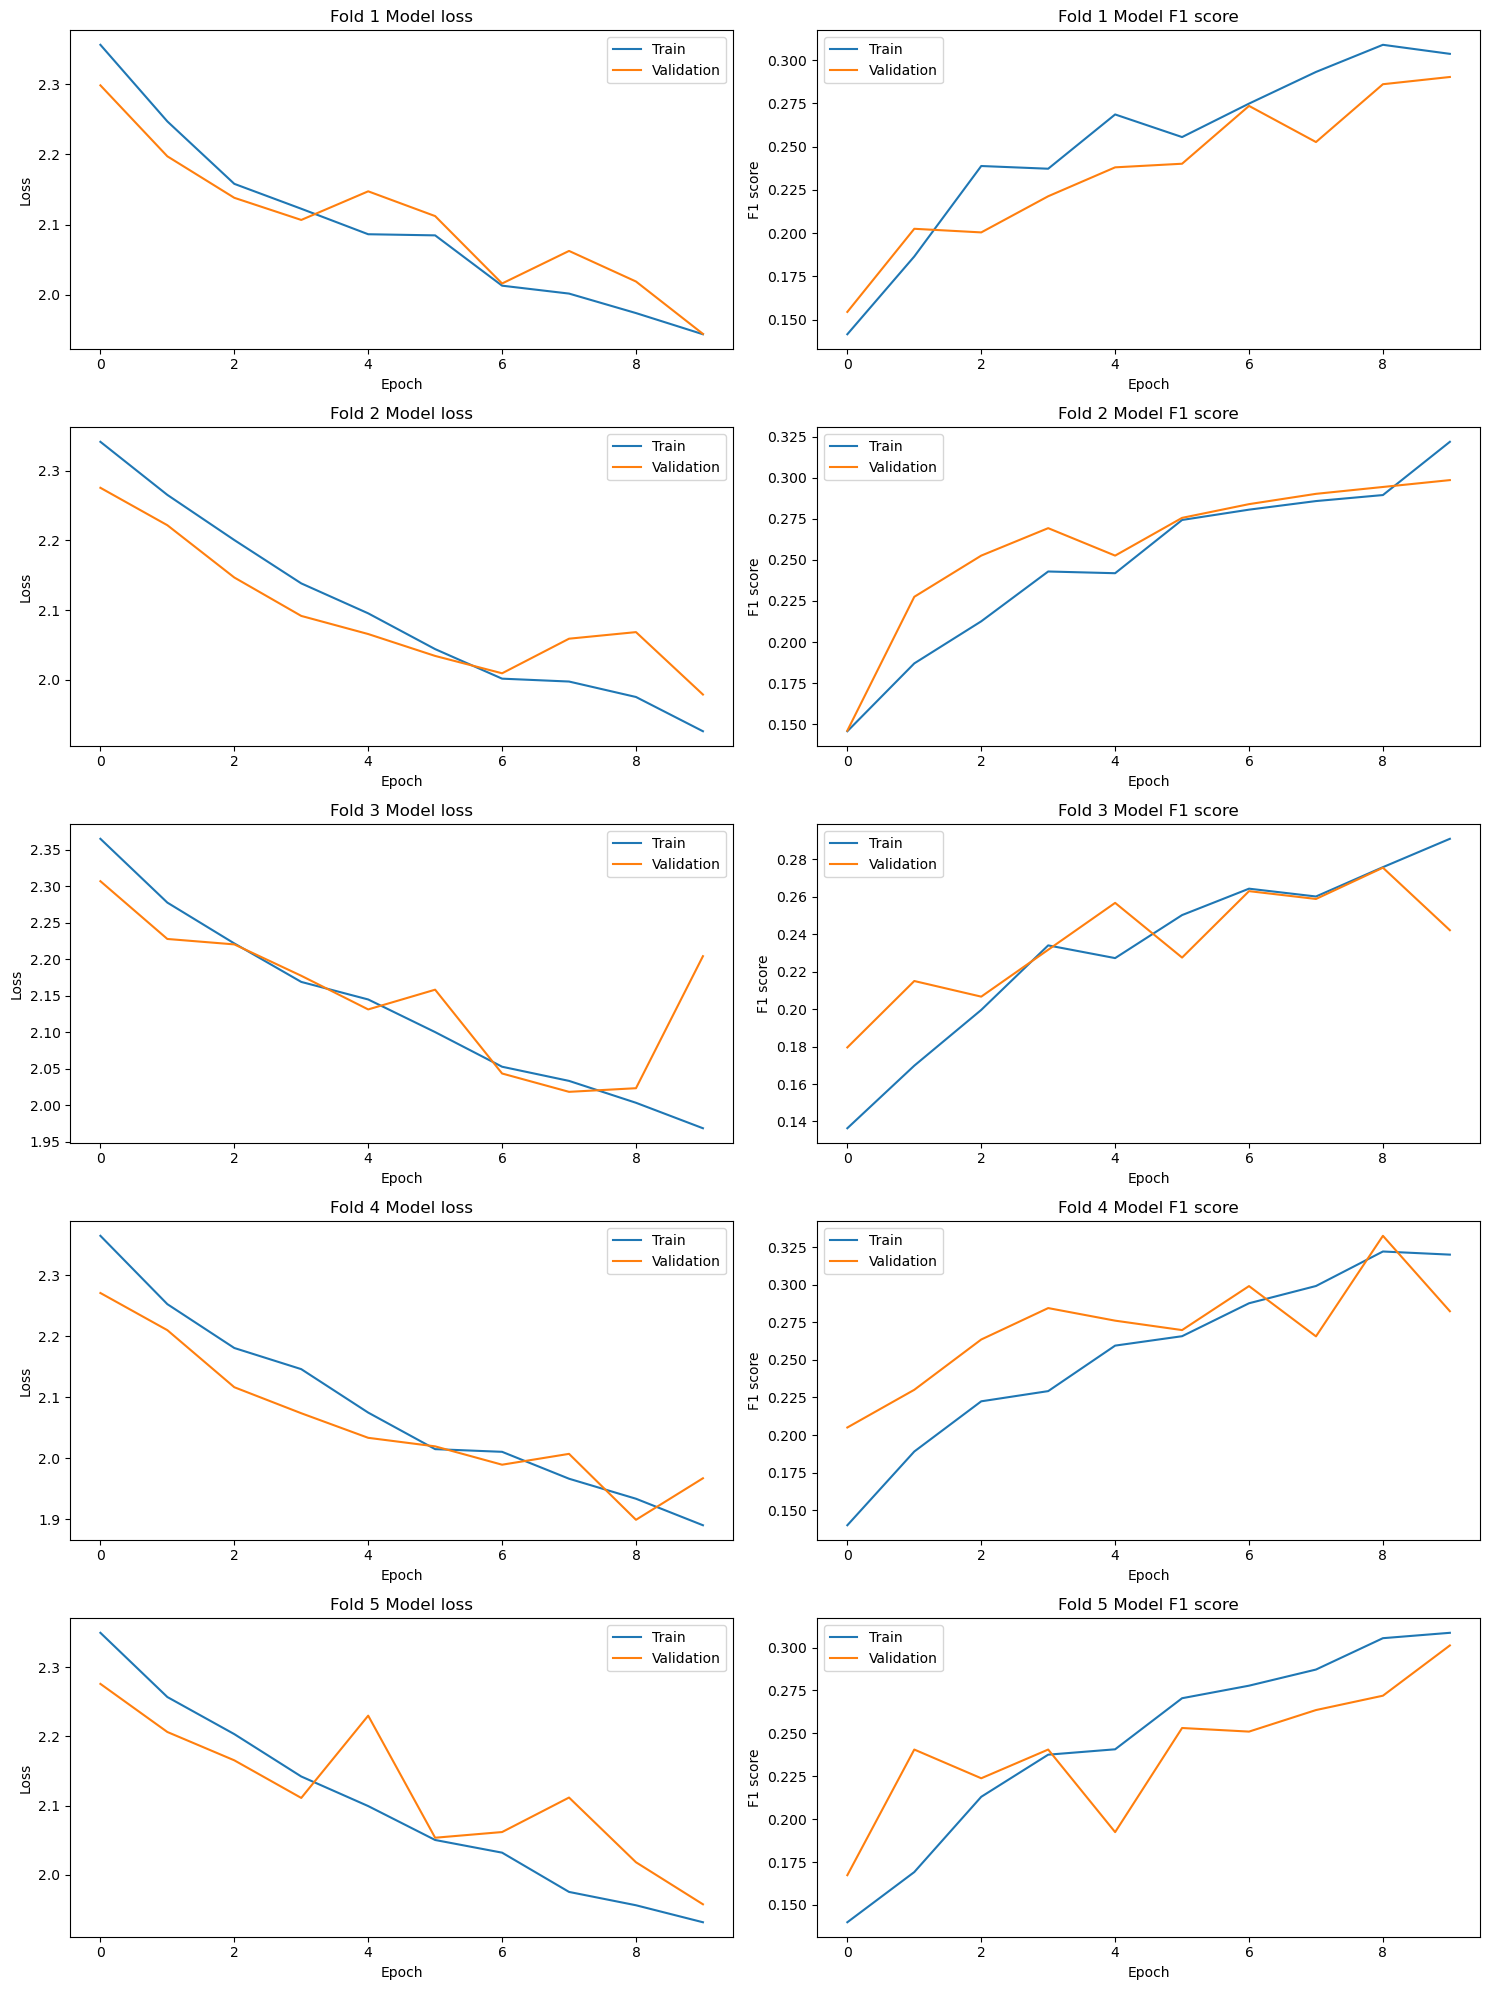

In [24]:
n_splits=5
epoch = 10
skf = StratifiedKFold(n_splits=n_splits)
metrics1 = { 'loss': [], 'val_loss': [], 'f1score' :[], 'val_f1score': [],
}

for train_idx, test_idx in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
    
    model = build_model_base(img_hw, 3, 32, 64)
    # since this is not binary, we should go ahead and one-hot encode the inputs
    y_train_fold_ohe = keras.utils.to_categorical(y_train_fold, NUM_CLASSES)
    y_test_fold_ohe = keras.utils.to_categorical(y_test_fold, NUM_CLASSES)
    
    history = model.fit(X_train_fold, y_train_fold_ohe, epochs=epoch, batch_size=32, verbose=2, validation_data=(X_test_fold,y_test_fold_ohe))
    
    test_score = model.evaluate(X_test_fold, y_test_fold_ohe)
    
    for key in metrics1.keys():
        metrics1[key].extend(history.history[key])
    print(test_score)   
plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

print(model.summary())
summarize_net(model, X_test, y_test, "Base model f1-score:")
plot_history(metrics1, n_splits, epoch)

#### 2.1.2 Base Model with different parameters
- Convolution - maxpooling twice
- number of features: 64 - 64
- kernel size: 5 * 5
- One dropout

Epoch 1/10


c:\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 - 7s - 125ms/step - f1score: 0.1301 - loss: 2.3745 - val_f1score: 0.1775 - val_loss: 2.3118
Epoch 2/10
60/60 - 6s - 93ms/step - f1score: 0.1761 - loss: 2.3082 - val_f1score: 0.1837 - val_loss: 2.2826
Epoch 3/10
60/60 - 5s - 91ms/step - f1score: 0.1829 - loss: 2.2604 - val_f1score: 0.1921 - val_loss: 2.2675
Epoch 4/10
60/60 - 5s - 91ms/step - f1score: 0.2059 - loss: 2.2267 - val_f1score: 0.2004 - val_loss: 2.2146
Epoch 5/10
60/60 - 5s - 91ms/step - f1score: 0.2064 - loss: 2.2013 - val_f1score: 0.2004 - val_loss: 2.1898
Epoch 6/10
60/60 - 6s - 92ms/step - f1score: 0.2330 - loss: 2.1758 - val_f1score: 0.2296 - val_loss: 2.1754
Epoch 7/10
60/60 - 6s - 93ms/step - f1score: 0.2335 - loss: 2.1564 - val_f1score: 0.2359 - val_loss: 2.1624
Epoch 8/10
60/60 - 6s - 99ms/step - f1score: 0.2576 - loss: 2.1111 - val_f1score: 0.2359 - val_loss: 2.1110
Epoch 9/10
60/60 - 6s - 92ms/step - f1score: 0.2534 - loss: 2.0815 - val_f1score: 0.2443 - val_loss: 2.0988
Epoch 10/10
60/60 - 6s - 92ms/step - f

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_34 (RandomFlip)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_35 (RandomFlip)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_17              │ (None, 64, 64, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_179 (Conv2D)             │ (None, 64, 64, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_121               │ (None, 32, 32, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_180 (Conv2D)             │ (None, 32, 32, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_122               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,608,483 (25.21 MB)

 Trainable params: 2,202,827 (8.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,405,656 (16.81 MB)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


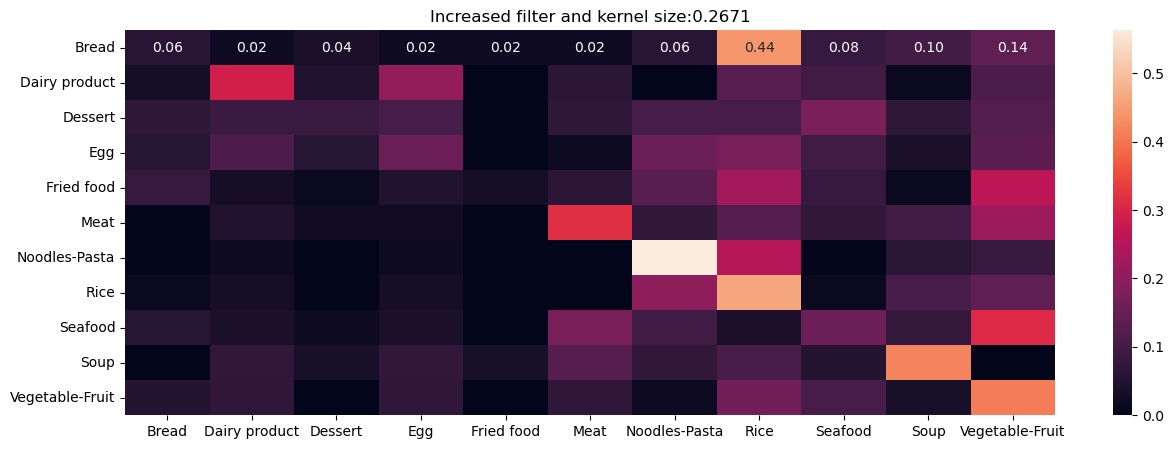

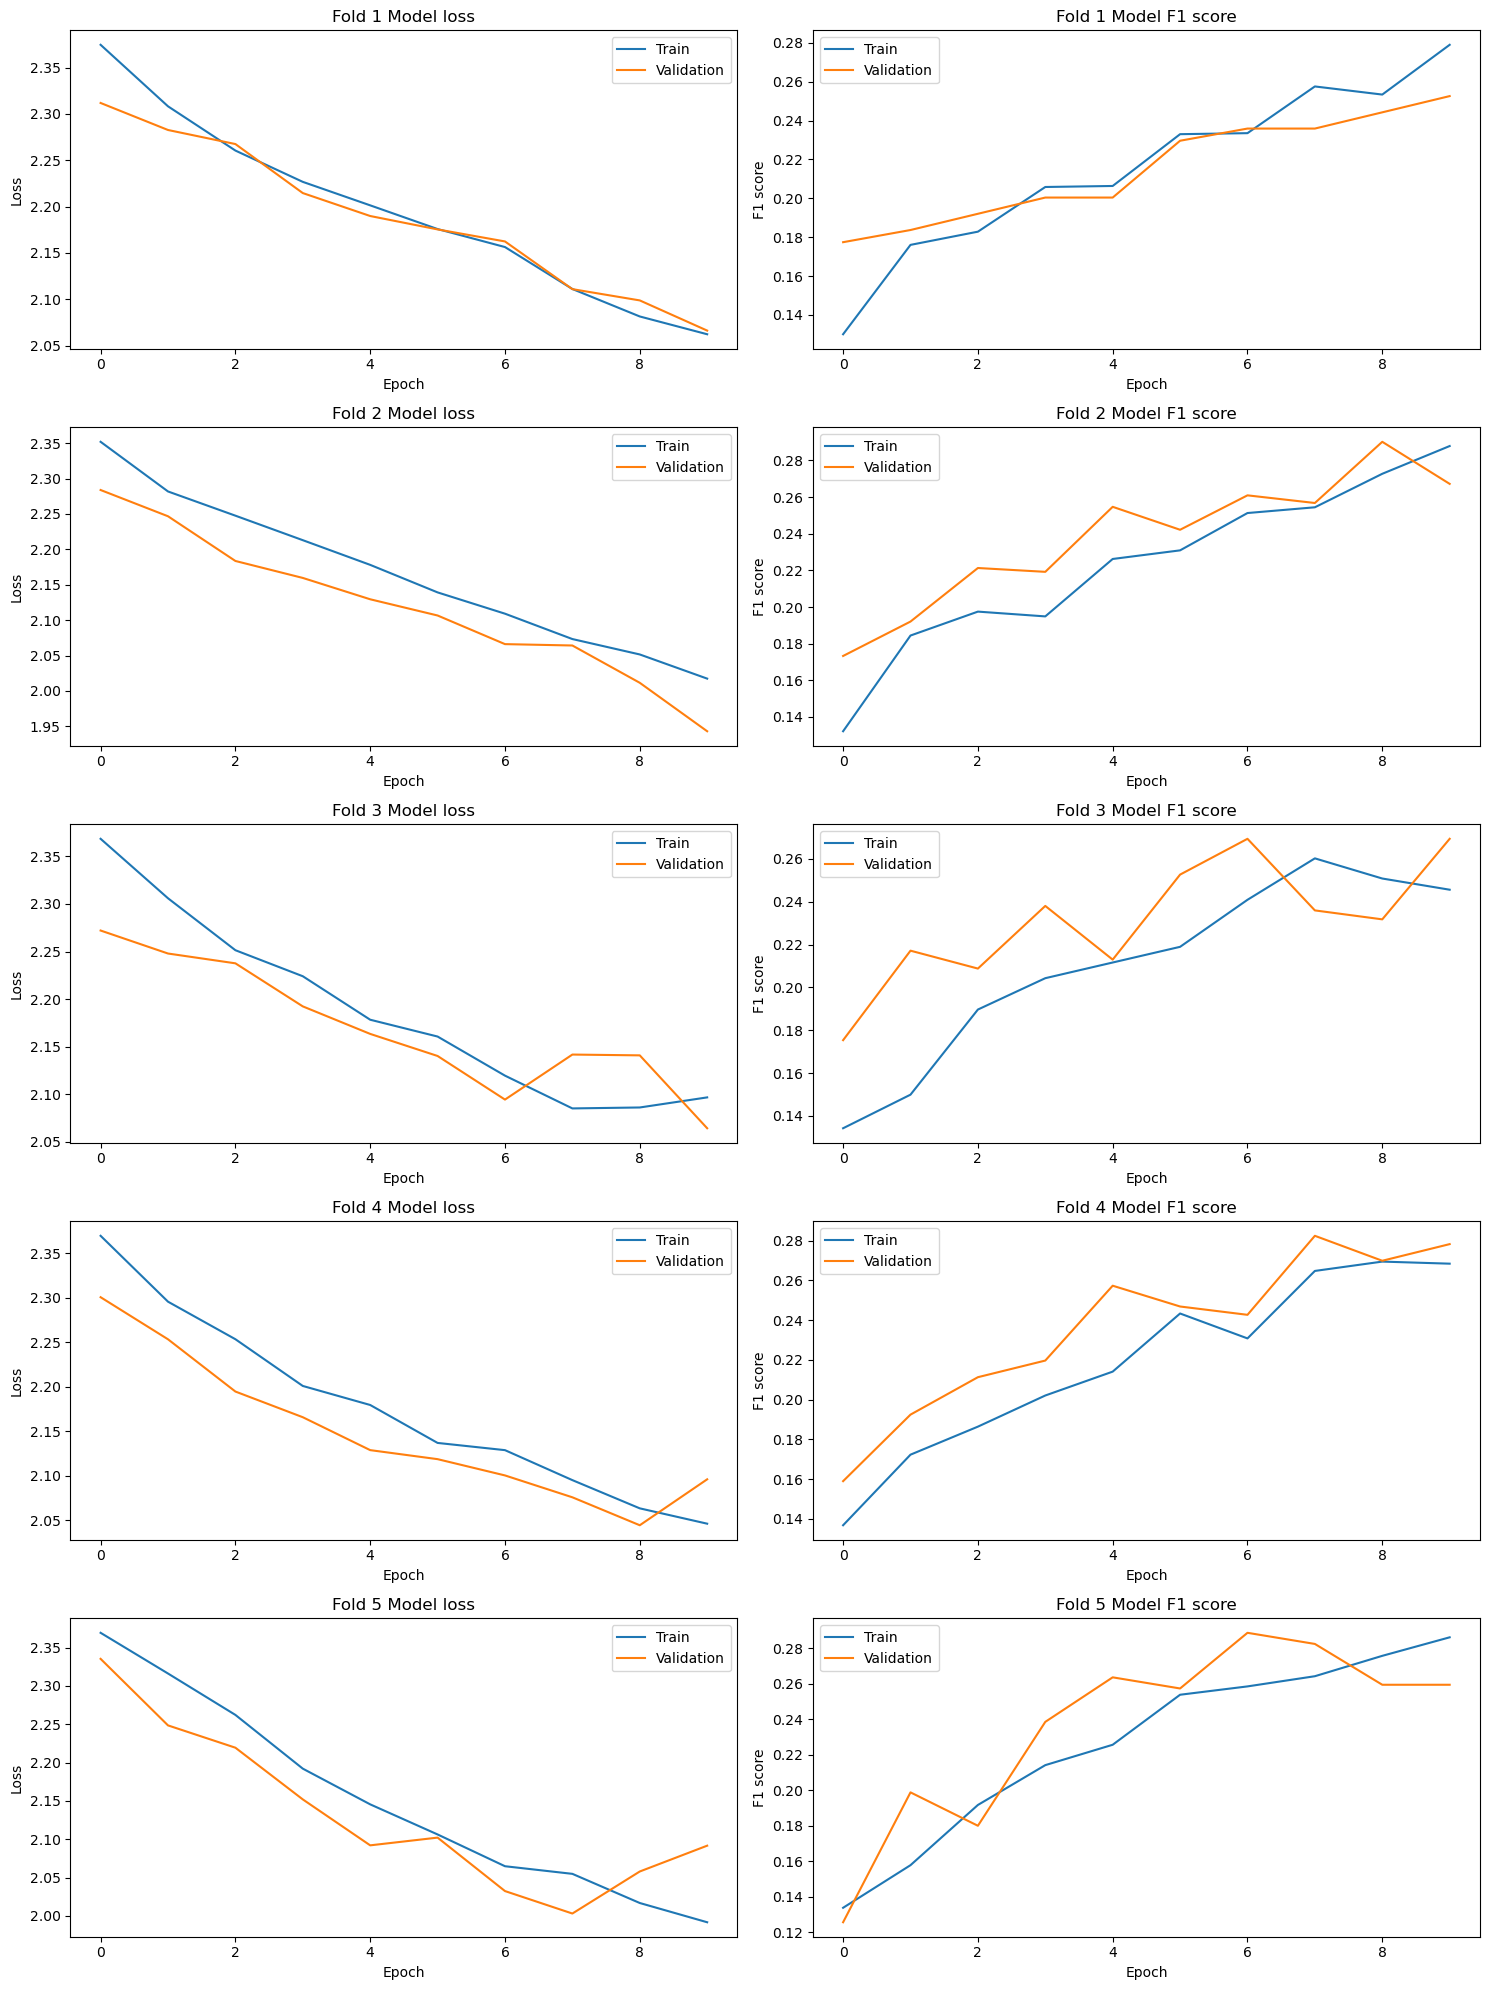

In [26]:
n_splits=5
epoch = 10
skf = StratifiedKFold(n_splits=n_splits)
metrics2 = { 'loss': [], 'val_loss': [], 'f1score' :[], 'val_f1score': [],
}

for train_idx, test_idx in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]
    
    model2 = build_model_base(img_hw, 5, 64, 64)
    # since this is not binary, we should go ahead and one-hot encode the inputs
    y_train_fold_ohe = keras.utils.to_categorical(y_train_fold, NUM_CLASSES)
    y_test_fold_ohe = keras.utils.to_categorical(y_test_fold, NUM_CLASSES)
    
    history2 = model2.fit(X_train_fold, y_train_fold_ohe, epochs=epoch, batch_size=32, verbose=2, validation_data=(X_test_fold,y_test_fold_ohe))
    
    test_score = model2.evaluate(X_test_fold, y_test_fold_ohe)
    
    print(test_score)
    
    for key in metrics2.keys():
        metrics2[key].extend(history2.history[key])
    
plot_model(
    model2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

print(model2.summary())
summarize_net(model2, X_test, y_test, "Increased filter and kernel size:")
plot_history(metrics2, n_splits, epoch)

#### 2.1.3 Different Architecture
- Resnet Style Bypass
- singe convolution layer- max pooling - single convolution layer - max pooling x_split(residual) - three convolution layers - residual added in - max pooling - 3 Dense layers with 2 dropouts
- number of features: 32 - 32 - 64 - 64 -32
- kernel size: 3 * 3 / 1 * 1
- two dropout
- he_uniform normalization
- l2 regularization

Epoch 1/10


c:\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - f1score: 0.1012 - loss: 2.8388 - val_f1score: 0.1503 - val_loss: 2.4127
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - f1score: 0.1527 - loss: 2.4049 - val_f1score: 0.1608 - val_loss: 2.3728
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - f1score: 0.1756 - loss: 2.3563 - val_f1score: 0.2067 - val_loss: 2.2949
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - f1score: 0.2109 - loss: 2.2762 - val_f1score: 0.2150 - val_loss: 2.2416
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - f1score: 0.2375 - loss: 2.2117 - val_f1score: 0.2568 - val_loss: 2.1829
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - f1score: 0.2627 - loss: 2.1195 - val_f1score: 0.2401 - val_loss: 2.1629
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - f1score: 0.2850 - loss: 2.0740 - val_f1score: 0.2672 - val_loss: 2.1426
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - f1score: 0.3022 - loss: 2.0340 - val_f1score: 0.2756 - val_loss: 2.1217
Epo

Model: "functional_85"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_201 (Conv2D) │ (None, 64, 64,    │        320 │ input_layer_25[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_135   │ (None, 32, 32,    │          0 │ conv2d_201[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_202 (Conv2D) │ (None, 32, 32,    │      9,248 │ max_pooling2d_13… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_136   │ (None, 16, 16,    │          0 │ conv2d_202[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 16, 16,    │      2,112 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 16, 16,    │     36,928 │ conv2d_203[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, 16, 16,    │      2,080 │ conv2d_204[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 16, 16,    │          0 │ conv2d_205[0][0], │
│                     │ 32)               │            │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_99       │ (None, 16, 16,    │          0 │ add_33[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_137   │ (None, 8, 8, 32)  │          0 │ activation_99[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_51          │ (None, 2048)      │          0 │ max_pooling2d_13… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_84          │ (None, 2048)      │          0 │ flatten_51[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 256)       │    524,544 │ dropout_84[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_100      │ (None, 256)       │          0 │ dense_117[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_85          │ (None, 256)       │          0 │ activation_100[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_118 (Dense)   │ (None, 11)        │      2,827 │ dropout_85[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,734,179 (6.62 MB)

 Trainable params: 578,059 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156,120 (4.41 MB)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


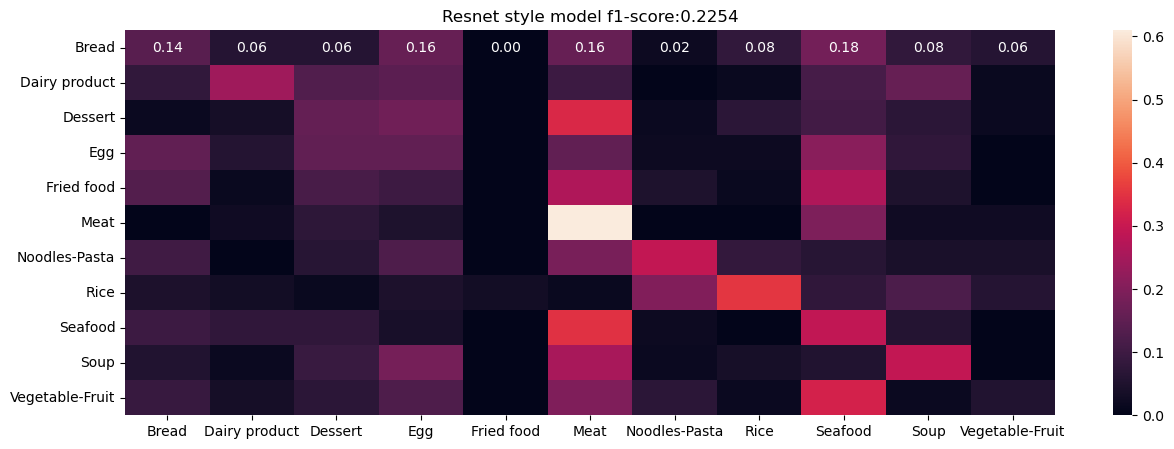

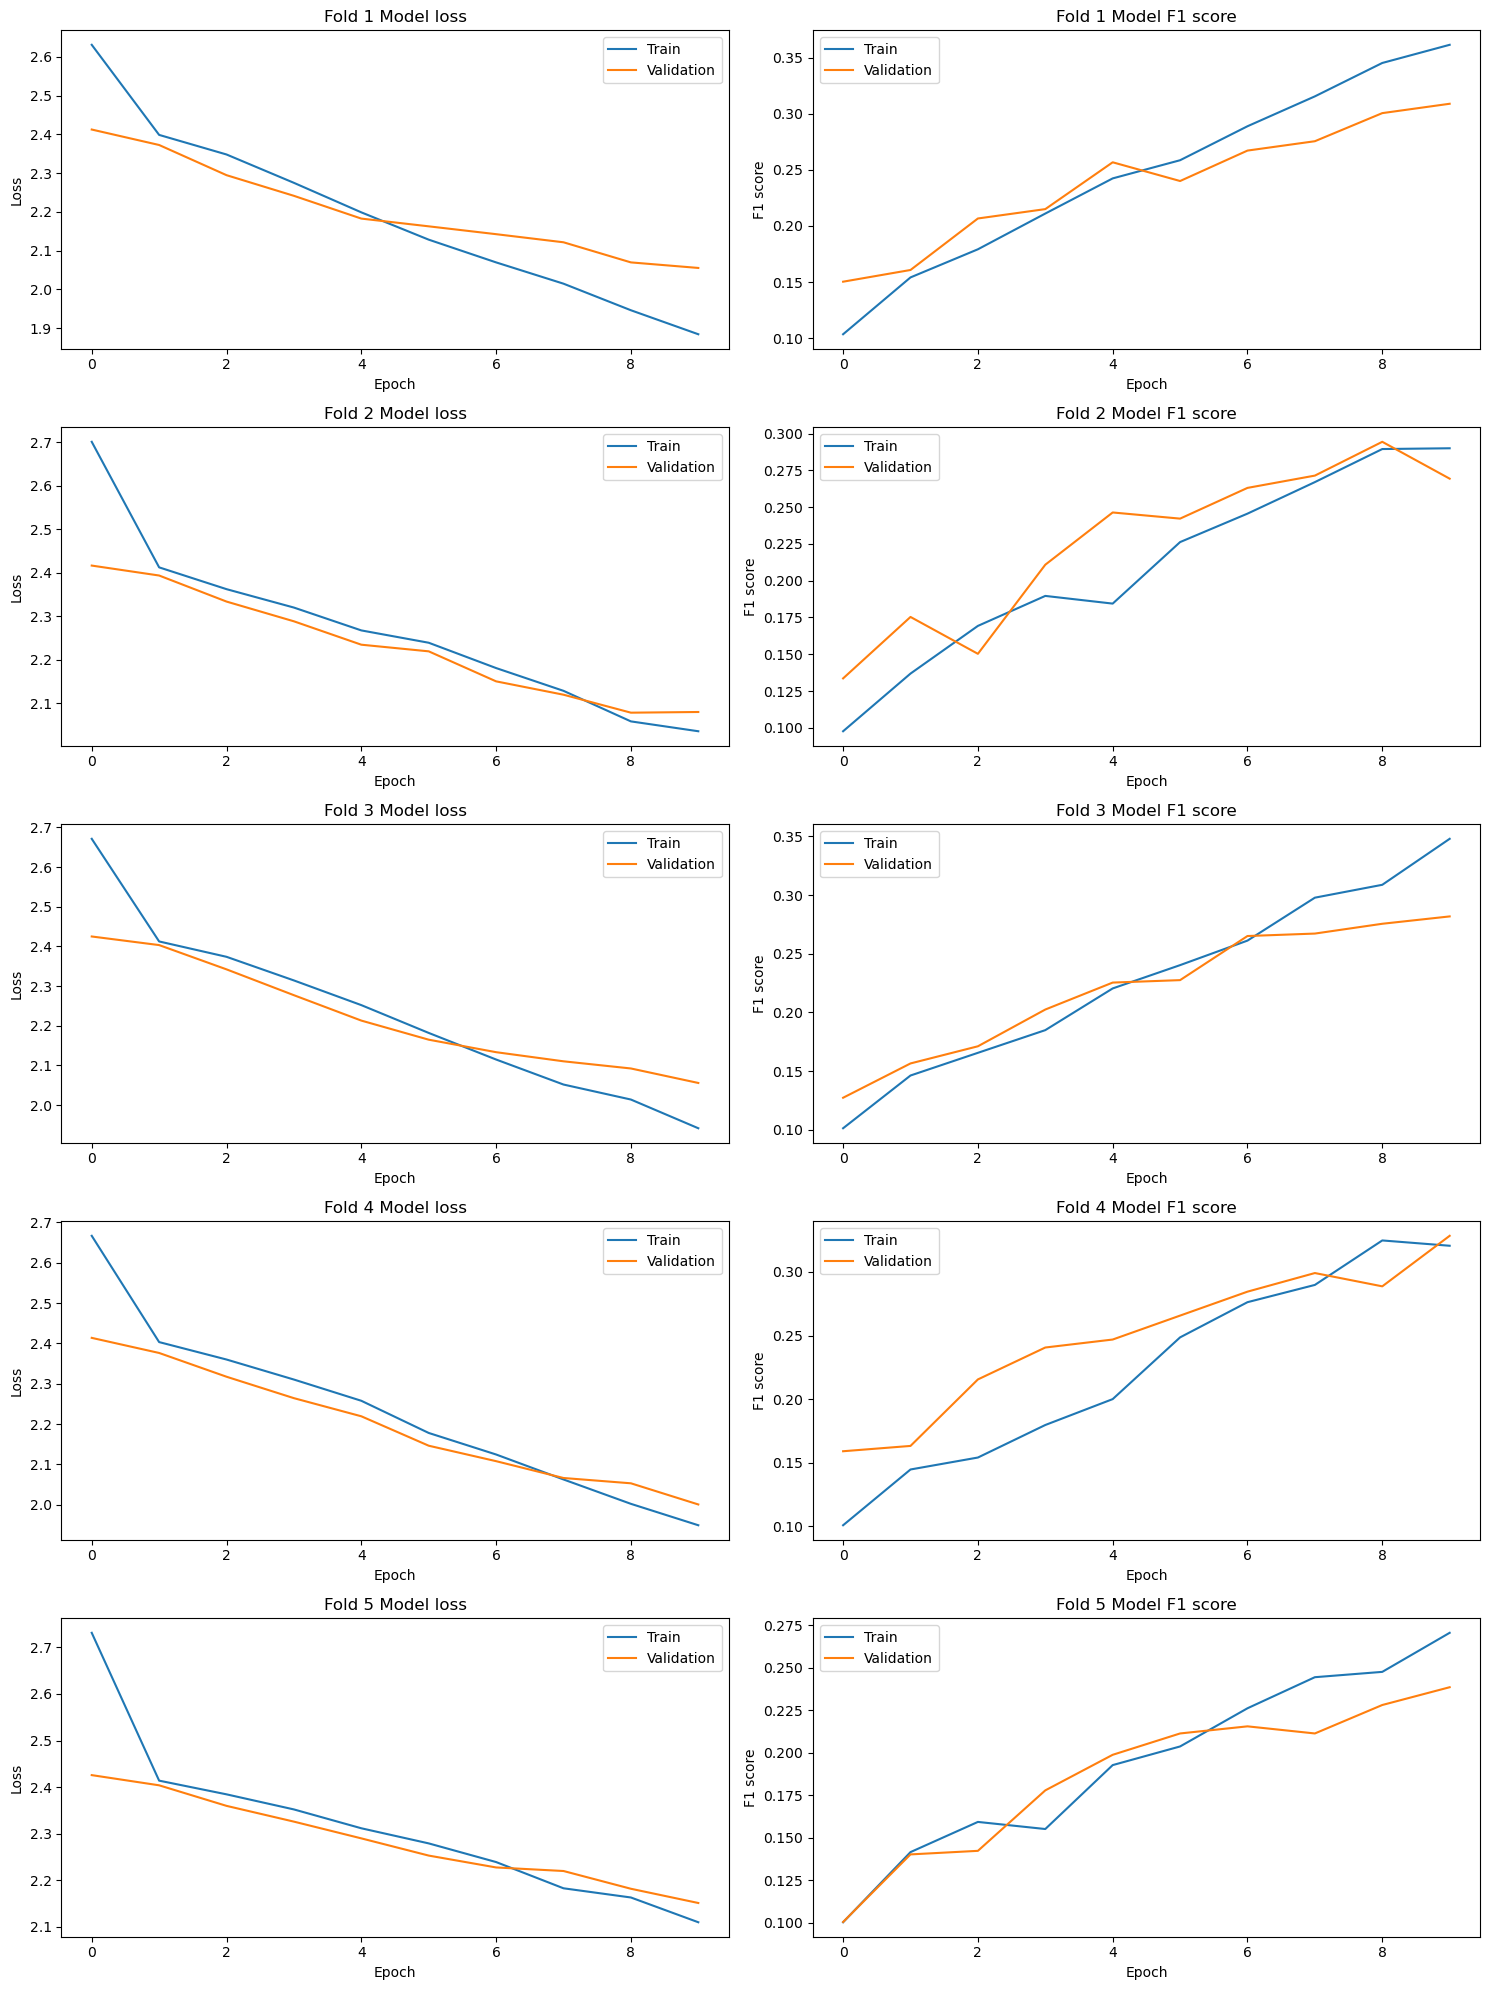

In [27]:
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

n_splits=5
epoch = 10
l2_lambda = 0.0001
skf = StratifiedKFold(n_splits=n_splits)
metrics3 = { 'loss': [], 'val_loss': [], 'f1score' :[], 'val_f1score': []}
input_holder = Input(shape=(img_hw, img_hw, 1))

for train_idx, test_idx in skf.split(X_train, y_train):
    
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    x = Conv2D(filters=32,
                input_shape = (input_holder),
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(input_holder)
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x)
    x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x_split)
    x = Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x)
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x)

    x = Add()([x, x_split])
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dropout(0.25)(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES)(x)
    x = Activation('softmax')(x)

    resnet = Model(inputs=input_holder,outputs=x)

    
    resnet.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=[F1Score(average='micro', name='f1score')])
    
    y_train_fold_ohe = keras.utils.to_categorical(y_train_fold, NUM_CLASSES)
    y_test_fold_ohe = keras.utils.to_categorical(y_test_fold, NUM_CLASSES)
    history3 = resnet.fit(X_train_fold, y_train_fold_ohe, batch_size=128, 
                      epochs=epoch, verbose=1,
                      validation_data=(X_test_fold,y_test_fold_ohe))
    for key in metrics3.keys():
        metrics3[key].extend(history3.history[key])
    
print(resnet.summary())
summarize_net(resnet, X_test, y_test, "Resnet style model f1-score:")
plot_history(metrics3, n_splits, epoch)

#### 2.1.4 Different Architecture with different parameters
- Resnet Style Bypass
- singe convolution layer- max pooling - single convolution layer - max pooling x_split(residual) - three convolution layers - residual added in - max pooling - 3 Dense layers(128 *2 and output layer) with 2 dropouts
- number of features: 64 - 32 - 64 - 64 -32
- kernel size: 3 * 3 / 1 * 1
- two dropout
- he_uniform normalization
- l2 regularization

Epoch 1/10


c:\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - f1score: 0.0968 - loss: 2.9922 - val_f1score: 0.1002 - val_loss: 2.4455
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - f1score: 0.1136 - loss: 2.4418 - val_f1score: 0.1127 - val_loss: 2.4385
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - f1score: 0.1163 - loss: 2.4357 - val_f1score: 0.1190 - val_loss: 2.4143
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - f1score: 0.1340 - loss: 2.4102 - val_f1score: 0.1775 - val_loss: 2.3626
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - f1score: 0.1630 - loss: 2.3648 - val_f1score: 0.1942 - val_loss: 2.3049
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - f1score: 0.1817 - loss: 2.3182 - val_f1score: 0.2317 - val_loss: 2.2577
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - f1score: 0.2275 - loss: 2.2409 - val_f1score: 0.2171 - val_loss: 2.2462
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - f1score: 0.2581 - loss: 2.1678 - val_f1score: 0.2401 - val_loss: 2.1730
Epo

Model: "functional_95"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_226 (Conv2D) │ (None, 64, 64,    │        640 │ input_layer_26[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_150   │ (None, 32, 32,    │          0 │ conv2d_226[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_227 (Conv2D) │ (None, 32, 32,    │     18,464 │ max_pooling2d_15… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_151   │ (None, 16, 16,    │          0 │ conv2d_227[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_228 (Conv2D) │ (None, 16, 16,    │      2,112 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_229 (Conv2D) │ (None, 16, 16,    │     36,928 │ conv2d_228[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_230 (Conv2D) │ (None, 16, 16,    │      2,080 │ conv2d_229[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 16, 16,    │          0 │ conv2d_230[0][0], │
│                     │ 32)               │            │ max_pooling2d_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_114      │ (None, 16, 16,    │          0 │ add_38[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_152   │ (None, 8, 8, 32)  │          0 │ activation_114[0… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_56          │ (None, 2048)      │          0 │ max_pooling2d_15… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 256)       │    524,544 │ flatten_56[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_94          │ (None, 256)       │          0 │ dense_131[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 256)       │     65,792 │ dropout_94[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_115      │ (None, 256)       │          0 │ dense_132[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 256)       │          0 │ activation_115[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,960,163 (7.48 MB)

 Trainable params: 653,387 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,306,776 (4.98 MB)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


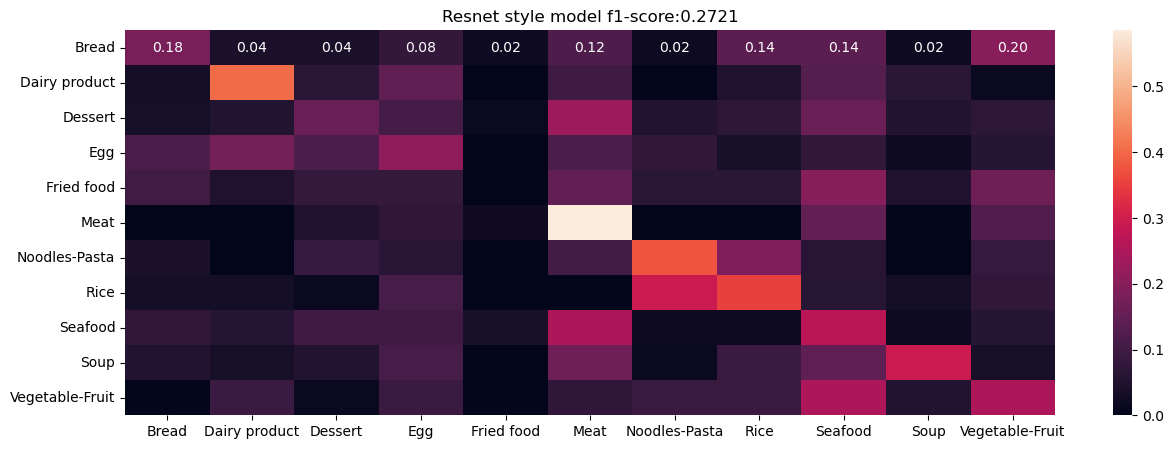

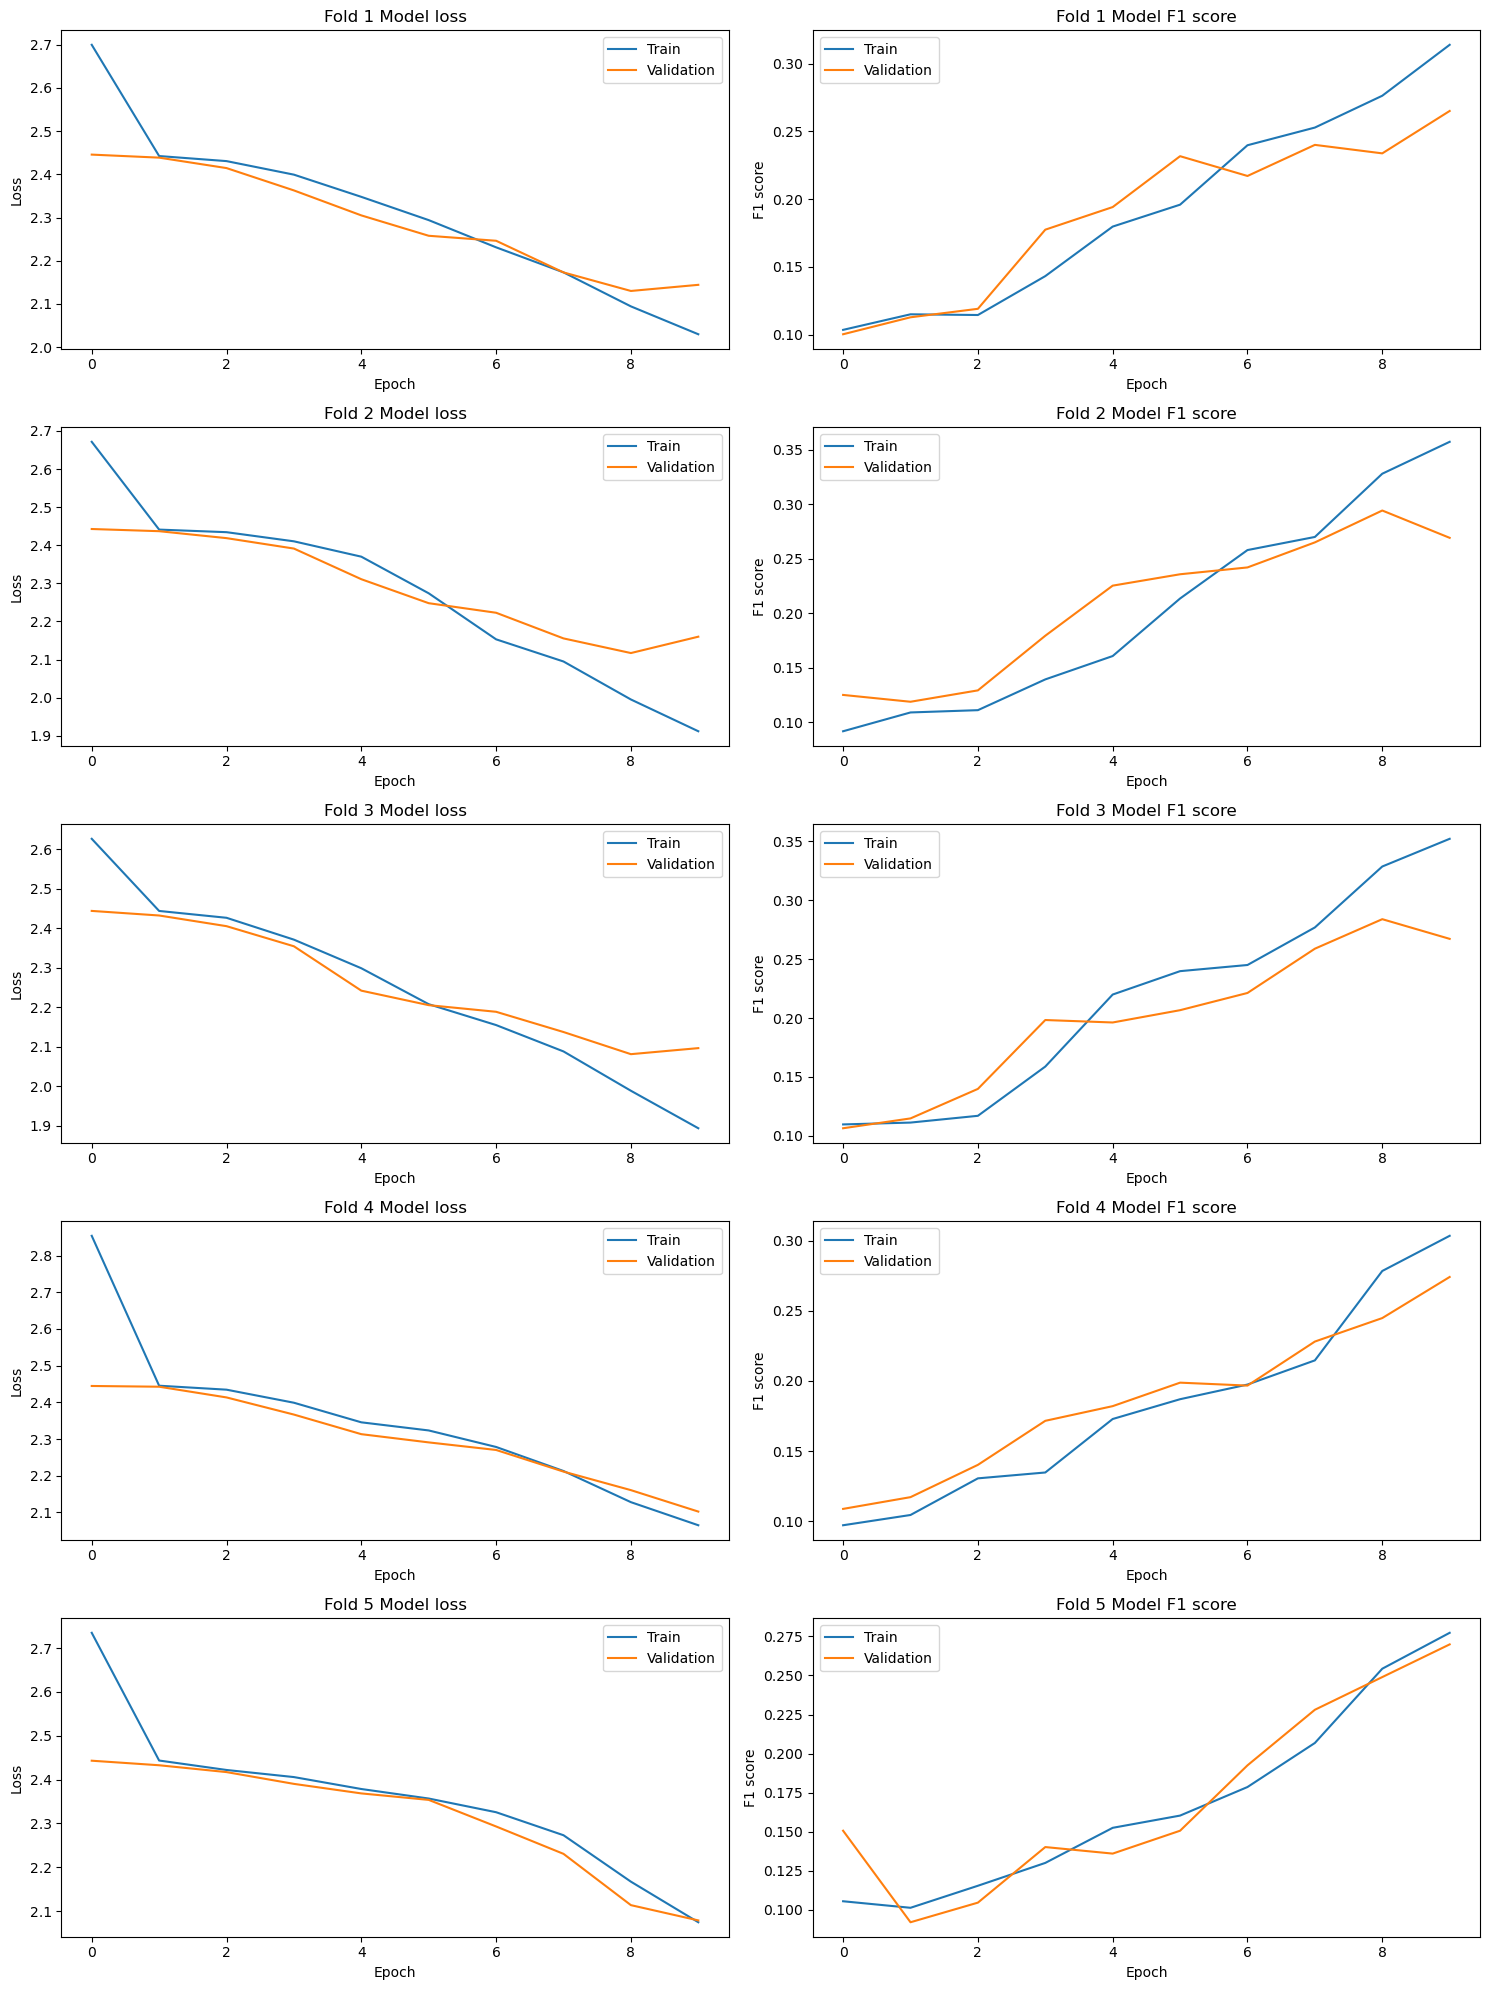

In [28]:
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.layers import average, concatenate
from tensorflow.keras.models import Model

n_splits=5
epoch = 10
l2_lambda = 0.0001
skf = StratifiedKFold(n_splits=n_splits)
metrics4 = { 'loss': [], 'val_loss': [], 'f1score' :[], 'val_f1score': []}
input_holder = Input(shape=(img_hw, img_hw, 1))

for train_idx, test_idx in skf.split(X_train, y_train):
    
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    x = Conv2D(filters=64,
                input_shape = (input_holder),
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(input_holder)
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Conv2D(filters=32,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x)
    x_split = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    x = Conv2D(filters=64,
                kernel_size=(1,1),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x_split)
    x = Conv2D(filters=64,
                kernel_size=(3,3),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x)
    x = Conv2D(filters=32,
                kernel_size=(1,1),
                kernel_initializer='he_uniform', 
                kernel_regularizer=l2(l2_lambda),
                padding='same', 
                activation='relu', 
                data_format="channels_last")(x)

    x = Add()([x, x_split])
    x = Activation("relu")(x)

    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    x = Flatten()(x)
    x = Dense(256)(x)   
    x = Dropout(0.25)(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(NUM_CLASSES)(x)
    x = Activation('softmax')(x)

    resnet2 = Model(inputs=input_holder,outputs=x)

    
    resnet2.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=[F1Score(average='micro', name='f1score')])
    
    y_train_fold_ohe = keras.utils.to_categorical(y_train_fold, NUM_CLASSES)
    y_test_fold_ohe = keras.utils.to_categorical(y_test_fold, NUM_CLASSES)
    history4 = resnet2.fit(X_train_fold, y_train_fold_ohe, batch_size=128, 
                      epochs=epoch, verbose=1,
                      validation_data=(X_test_fold,y_test_fold_ohe))
    for key in metrics4.keys():
        metrics4[key].extend(history4.history[key])
    
print(resnet2.summary())
summarize_net(resnet2, X_test, y_test, "Resnet style model f1-score:")
plot_history(metrics4, n_splits, epoch)

The results shows that all the models converge at their loss scores.<br>
In spite of complex structures such as resnet style residucal connection did not improve the outcome much.<br><br> 
The best perfomance was shown by the basic model with two convolution layers, two max pooling,and two dense layers.<br> Kernel size was increased from 3x3 to 5x5 and the number of filters increased to 64.<br>
Wheter the four models actually makes significant difference in terms of statistics will be discussed below.<br>

#### 2.2. Results Comparision

In [29]:
def plot_all(histories, metric, metric_name):
    plt.figure(figsize=(14, 10))

    for i, history in enumerate(histories):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history[f'val_{metric}'])
        plt.title(f'Model {i+1} {metric_name}')
        plt.ylabel(metric_name)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

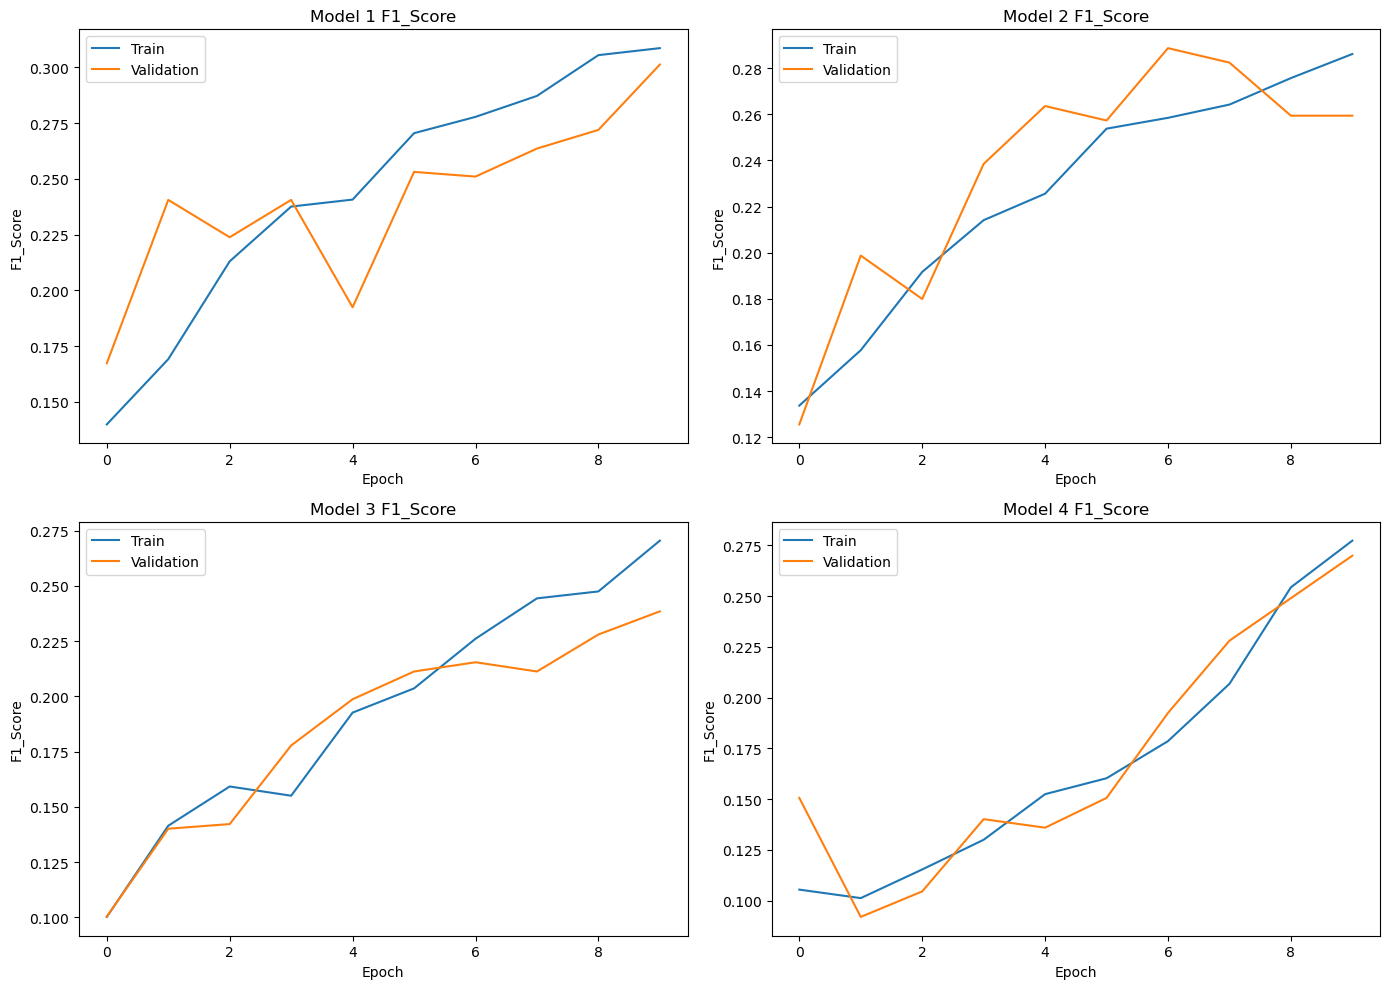

In [30]:
plot_all([history, history2, history3, history4], 'f1score', 'F1_Score')

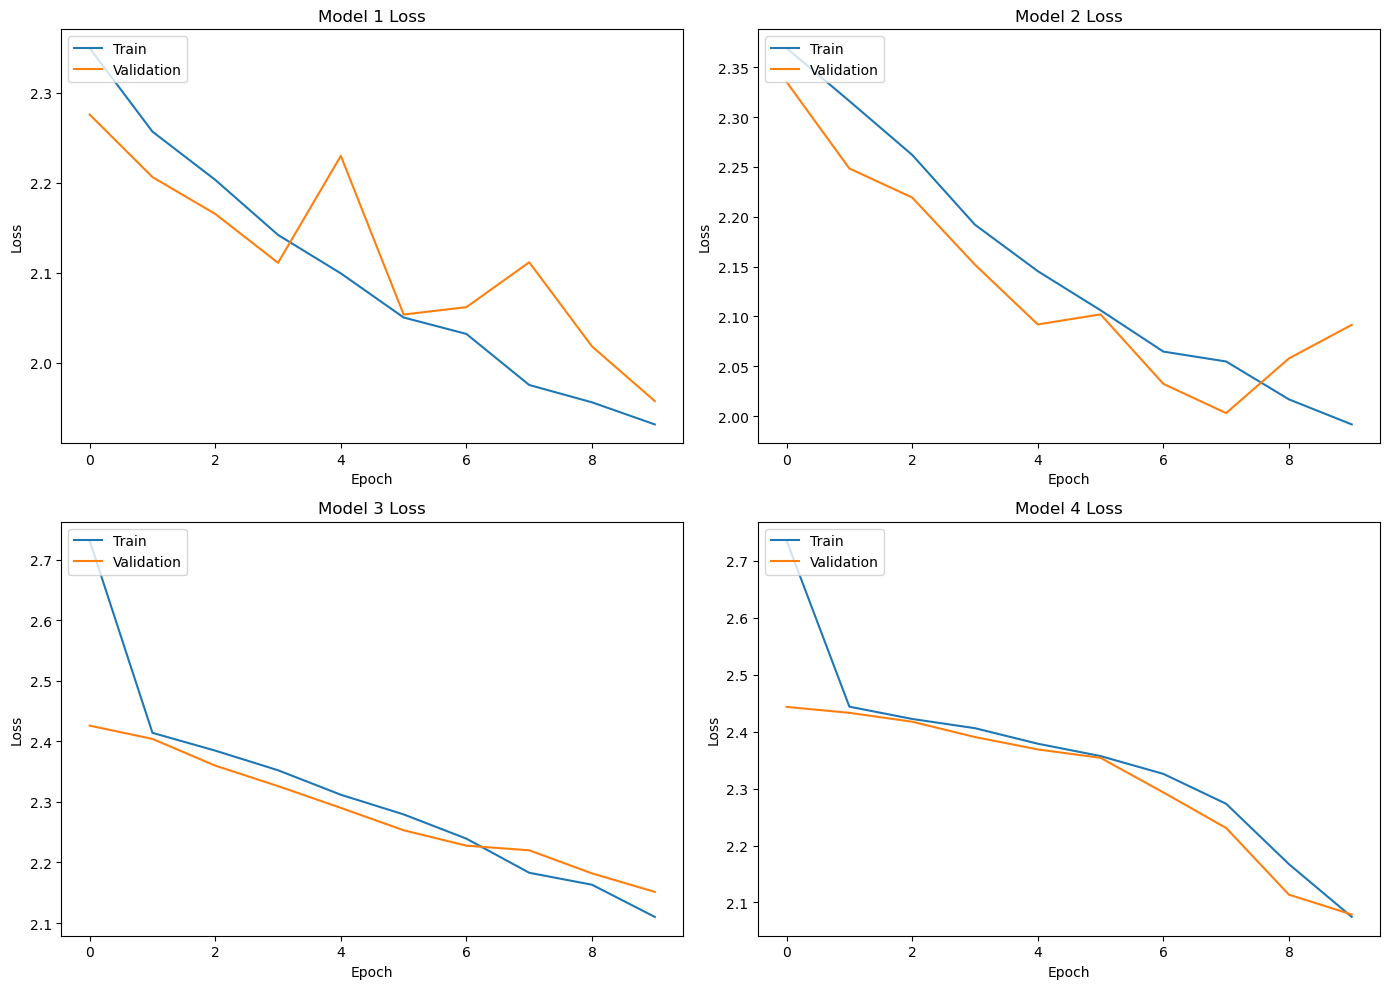

In [31]:
plot_all([history, history2, history3, history4], 'loss', 'Loss')

#### 2.2.1 Comparision between CNN models

In [32]:
def confidence_interval(critA, critB):
    e = (1 - np.array(critA)) - (1 - np.array(critB))    
    t = 2.26/np.sqrt(10)
    stdtot = np.std(e)
    dbar = np.mean(e)
    return dbar - t*stdtot, dbar+t*stdtot

Siginificance testing based on the 95% confidence interval.

In [36]:
model1_val_score = history.history['val_f1score']
model2_val_score = history2.history['val_f1score']
model3_val_score = history3.history['val_f1score']
model4_val_score = history4.history['val_f1score']

print("model1 vs. model2: ", confidence_interval(model1_val_score, model2_val_score))
print("model1 vs. model3:  ", confidence_interval(model1_val_score, model3_val_score))
print("model1 vs. model4 : ", confidence_interval(model1_val_score, model4_val_score))
print("model2 vs. model3: ", confidence_interval(model2_val_score, model3_val_score))
print("model2 vs. model4: ", confidence_interval(model2_val_score, model4_val_score))
print("model3 vs. model4: ", confidence_interval(model3_val_score, model4_val_score))

model1 vs. model2:  (-0.031894301610481623, 0.02143405302096594)
model1 vs. model3:   (-0.07370634719390012, -0.034661832008179655)
model1 vs. model4 :  (-0.10007312819950444, -0.038420582556797436)
model2 vs. model3:  (-0.06206008557469857, -0.03584784503786552)
model2 vs. model4:  (-0.10079341511578782, -0.027240047050998355)
model3 vs. model4:  (-0.04297658978364088, 0.012851058229418772)


According to the significance testing, there are no difference between model1 and model2,and model3 and model4 in the 95% confidence interval, including 0 in their range.<br>
It could be due to the fact that those models have the same architecture with different parameters.<br><br>
When you look at the comparision between base models(model1 and 2) and complex resnet style models(model 3 and 4), the confidence interval does not include 0 in their range.<br> This indicates that there is significant difference between the models statistically.<br>
The entire range being negative shows that the former model performs better than the latter.<br><br>
Interestingly, the models with less complex architecture(model1 and 2) performs better for this classification task.


#### 2.2.2 Comparision between CNN and MLP

In [46]:
def build_mlp(unit1):
    mlp = Sequential()
    mlp.add( Flatten() )
    mlp.add( Dense(input_dim=1, units=unit1, 
                activation='relu') )
    mlp.add( Dropout(0.20) )
    mlp.add( Dense(NUM_CLASSES, activation='softmax') )

    mlp.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=[keras.metrics.AUC()])
    return mlp

In [65]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [79]:
def compute_avg_roc(y_test, yhat, NUM_CLASSES):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], yhat[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), yhat.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(NUM_CLASSES):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= NUM_CLASSES
    
    fpr["avg"] = all_fpr
    tpr["avg"] = mean_tpr
    roc_auc["avg"] = auc(fpr["avg"], tpr["avg"])
    
    return fpr, tpr, roc_auc

In [80]:
def plot_avg_roc(fpr_cnn, tpr_cnn, roc_auc_cnn, fpr_mlp, tpr_mlp, roc_auc_mlp):
    plt.figure(figsize=(10, 8))
    
    plt.plot(fpr_cnn["avg"], tpr_cnn["avg"], color='blue', lw=2, label='CNN (area = {:.2f})'.format(roc_auc_cnn["avg"]))
    plt.plot(fpr_mlp["avg"], tpr_mlp["avg"], color='red', lw=2, label='MLP (area = {:.2f})'.format(roc_auc_mlp["avg"]))
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.show()

Used generative AI for applying ROC to multiclass problem

In [76]:
labels = ['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat','Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']

def summarize_roc(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    f1 = mt.roc_auc_score(y_test,yhat,average='macro')
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels,yticklabels=labels)
    plt.title(title_text+'{:.4f}'.format(f1))

Epoch 1/3


c:\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 - 1s - 29ms/step - auc_98: 0.5970 - loss: 2.5160 - val_auc_98: 0.6115 - val_loss: 2.4404
Epoch 2/3
50/50 - 0s - 6ms/step - auc_98: 0.7386 - loss: 2.1074 - val_auc_98: 0.6294 - val_loss: 2.4445
Epoch 3/3
50/50 - 0s - 6ms/step - auc_98: 0.8225 - loss: 1.8002 - val_auc_98: 0.6332 - val_loss: 2.4695
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/3
50/50 - 5s - 100ms/step - f1score: 0.5379 - loss: 1.2582 - val_f1score: 0.5150 - val_loss: 1.4325
Epoch 2/3
50/50 - 5s - 99ms/step - f1score: 0.5542 - loss: 1.2358 - val_f1score: 0.5113 - val_loss: 1.3121
Epoch 3/3
50/50 - 5s - 99ms/step - f1score: 0.5661 - loss: 1.2216 - val_f1score: 0.5376 - val_loss: 1.2783
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Epoch 1/3


c:\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 - 1s - 29ms/step - auc_99: 0.5813 - loss: 2.5648 - val_auc_99: 0.6131 - val_loss: 2.4596
Epoch 2/3
50/50 - 0s - 6ms/step - auc_99: 0.7465 - loss: 2.0690 - val_auc_99: 0.6223 - val_loss: 2.4250
Epoch 3/3
50/50 - 0s - 6ms/step - auc_99: 0.8144 - loss: 1.8273 - val_auc_99: 0.6077 - val_loss: 2.5324
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/3
50/50 - 5s - 104ms/step - f1score: 0.5480 - loss: 1.2267 - val_f1score: 0.6015 - val_loss: 1.1829
Epoch 2/3
50/50 - 5s - 99ms/step - f1score: 0.5310 - loss: 1.2545 - val_f1score: 0.6053 - val_loss: 1.1231
Epoch 3/3
50/50 - 5s - 99ms/step - f1score: 0.5555 - loss: 1.2045 - val_f1score: 0.5777 - val_loss: 1.2659
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Epoch 1/3


c:\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 - 1s - 29ms/step - auc_100: 0.5858 - loss: 2.5407 - val_auc_100: 0.5915 - val_loss: 2.4624
Epoch 2/3
50/50 - 0s - 6ms/step - auc_100: 0.7414 - loss: 2.0778 - val_auc_100: 0.6037 - val_loss: 2.5210
Epoch 3/3
50/50 - 0s - 6ms/step - auc_100: 0.8191 - loss: 1.8009 - val_auc_100: 0.6178 - val_loss: 2.4915
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/3
50/50 - 5s - 100ms/step - f1score: 0.5545 - loss: 1.2276 - val_f1score: 0.5546 - val_loss: 1.2801
Epoch 2/3
50/50 - 5s - 100ms/step - f1score: 0.5727 - loss: 1.1834 - val_f1score: 0.5358 - val_loss: 1.4083
Epoch 3/3
50/50 - 5s - 99ms/step - f1score: 0.5357 - loss: 1.2512 - val_f1score: 0.5056 - val_loss: 1.4477
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


Model: "sequential_127"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_166 (Flatten)           │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_352 (Dense)               │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_205 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_353 (Dense)               │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,577,507 (6.02 MB)

 Trainable params: 525,835 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,051,672 (4.01 MB)

None


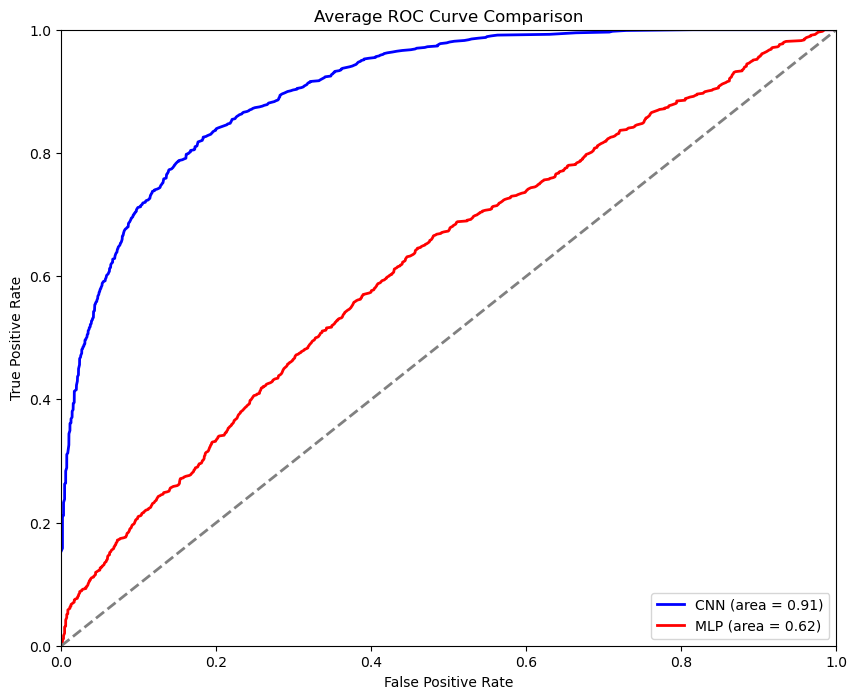

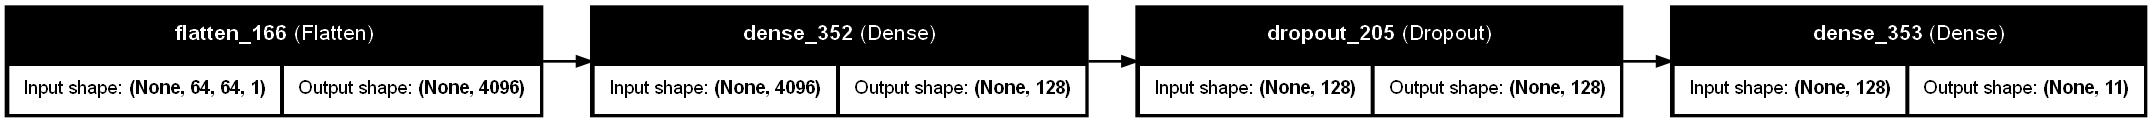

In [91]:
n_splits=3
epoch = 3
skf = StratifiedKFold(n_splits=n_splits)
fpr_cnns, tpr_cnns, roc_auc_cnns, fpr_mlps, tpr_mlps, roc_auc_mlps =[],[],[],[],[],[]

for train_idx, test_idx in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    mlp_model = build_mlp(128)
    
    y_train_fold_ohe = keras.utils.to_categorical(y_train_fold, NUM_CLASSES)
    y_test_fold_ohe = keras.utils.to_categorical(y_test_fold, NUM_CLASSES)
    
    mlp_model.fit(X_train_fold, y_train_fold_ohe, batch_size=32, epochs=epoch, shuffle=True, verbose=2, validation_data=(X_test_fold,y_test_fold_ohe))
    mlp_yhat = mlp_model.predict(X_test_fold)
    
    cnn_model = model2
    cnn_model.fit(X_train_fold, y_train_fold_ohe, batch_size=32, epochs=epoch, shuffle=True, verbose=2, validation_data=(X_test_fold,y_test_fold_ohe))
    cnn_yhat = cnn_model.predict(X_test_fold)

    fpr_cnn, tpr_cnn, roc_auc_cnn = compute_avg_roc(y_test_fold_ohe, cnn_yhat,NUM_CLASSES)
    fpr_mlp, tpr_mlp, roc_auc_mlp = compute_avg_roc(y_test_fold_ohe, mlp_yhat,NUM_CLASSES)
    
    fpr_cnns.append(fpr_cnn['avg'])
    tpr_cnns.append(tpr_cnn['avg'])
    roc_auc_cnns.append(roc_auc_cnn['avg'])
    fpr_mlps.append(fpr_mlp['avg'])
    tpr_mlps.append(tpr_mlp['avg'])
    roc_auc_mlps.append(roc_auc_mlp['avg'])
    
print(mlp_model.summary())
plot_avg_roc(fpr_cnn, tpr_cnn, roc_auc_cnn, fpr_mlp, tpr_mlp, roc_auc_mlp)    
plot_model(
    mlp_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96)


Since both lines are above the diagonal line, both model perform better than random guess.<br>
The ROC of CNN model is closer to the top-left corner with AUC 0.89, indicating that the classifier perform really well.<br>
Whereas, the ROC of MLP model is closer to the diagonal line with AUC 0.60, indicating that the model still performs better than random guess but performs worse than CNN model.<br><br>



In [92]:
from scipy import stats

cnn_aucs = np.array(roc_auc_cnns)
mlp_aucs = np.array(roc_auc_mlps)

t_stat, p_value = stats.ttest_rel(cnn_aucs, mlp_aucs)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

t-statistic: 32.59542659082619, p-value: 0.0009398835450609914


DeLong's test has been performed for the statistical significance.<br>
P-value shows 0.0009, which is lower than 0.05.<br>
The results shows that the the CNN model is significantly better than MPL model alone.

### 3. Exceptional Work

In [108]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

#### 3.1. Loading data in colors

In [99]:
def load_and_resize_image(base_folder, target_size, num):
    images, labels = [], []
    categories = os.listdir(base_folder)
    
    for category in categories:
        category_path = os.path.join(base_folder, category)
        if not os.path.isdir(category_path):
            continue
        filenames = os.listdir(category_path)
        random.shuffle(filenames)
        for filename in filenames[:num//len(categories)]:
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                img_path = os.path.join(category_path, filename) 
                img = Image.open(img_path)
                img_resized = img.resize(target_size, Image.LANCZOS)
                img_array = np.array(img_resized)
                images.append(img_array)
                labels.append(category)
    return np.array(images), np.array(labels) 
target_size = (64,64)

# Load the data in colors this time to use resnet
X, y = load_and_resize_image(folder_path, target_size, 3000)

In [101]:
from sklearn.preprocessing import LabelEncoder
# Preprocess the data
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

X = X.reshape((X.shape[0],64,64,3))
img_hw = 64
print(X.shape)
print(y.shape)


y_pd = pd.Series(y)
NUM_CLASSES=len(y_pd.unique())
print(NUM_CLASSES)
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape,'\n', X_test.shape)


(2992, 64, 64, 3)
(2992,)


#### 3.2. Transfer Learning: Resnet50

In [110]:

if 'res_no_top' not in locals():
    res_no_top = ResNet50(weights='imagenet', include_top=False)

x = X_train[0]
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

%time preds = res_no_top.predict(x)
preds.shape

11
(2393, 64, 64, 3) 
 (599, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CPU times: total: 62.5 ms
Wall time: 77.3 ms


(1, 2, 2, 2048)

In [104]:
x_train = preprocess_input(X_train)
x_test = preprocess_input(X_test)

In [105]:
# Train on resnet
x_train_resnet = res_no_top.predict(x_train)
x_test_resnet = res_no_top.predict(x_test)
print(x_train_resnet.shape)

75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step
(2393, 2, 2, 2048)


Epoch 1/10
60/60 - 2s - 41ms/step - f1score: 0.0888 - loss: 3.8101 - val_f1score: 0.0814 - val_loss: 2.4193
Epoch 2/10
60/60 - 1s - 20ms/step - f1score: 0.1055 - loss: 2.4387 - val_f1score: 0.1002 - val_loss: 2.4049
Epoch 3/10
60/60 - 1s - 20ms/step - f1score: 0.1076 - loss: 2.4007 - val_f1score: 0.0981 - val_loss: 2.4044
Epoch 4/10
60/60 - 1s - 19ms/step - f1score: 0.1217 - loss: 2.3754 - val_f1score: 0.0960 - val_loss: 2.4024
Epoch 5/10
60/60 - 1s - 21ms/step - f1score: 0.1202 - loss: 2.3846 - val_f1score: 0.1023 - val_loss: 2.4074
Epoch 6/10
60/60 - 1s - 20ms/step - f1score: 0.1129 - loss: 2.3783 - val_f1score: 0.0960 - val_loss: 2.4030
Epoch 7/10
60/60 - 1s - 20ms/step - f1score: 0.1118 - loss: 2.3656 - val_f1score: 0.0919 - val_loss: 2.4019
Epoch 8/10
60/60 - 1s - 21ms/step - f1score: 0.1254 - loss: 2.3528 - val_f1score: 0.0939 - val_loss: 2.4005
Epoch 9/10
60/60 - 1s - 21ms/step - f1score: 0.1238 - loss: 2.3422 - val_f1score: 0.0919 - val_loss: 2.4032
Epoch 10/10
60/60 - 1s - 20m

Model: "functional_317"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_192 (InputLayer)    │ (None, 2, 2, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_223 (Flatten)           │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_480 (Dense)               │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_273 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_481 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_274 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_482 (Dense)               │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,498,083 (24.79 MB)

 Trainable params: 2,166,027 (8.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,332,056 (16.53 MB)

None
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


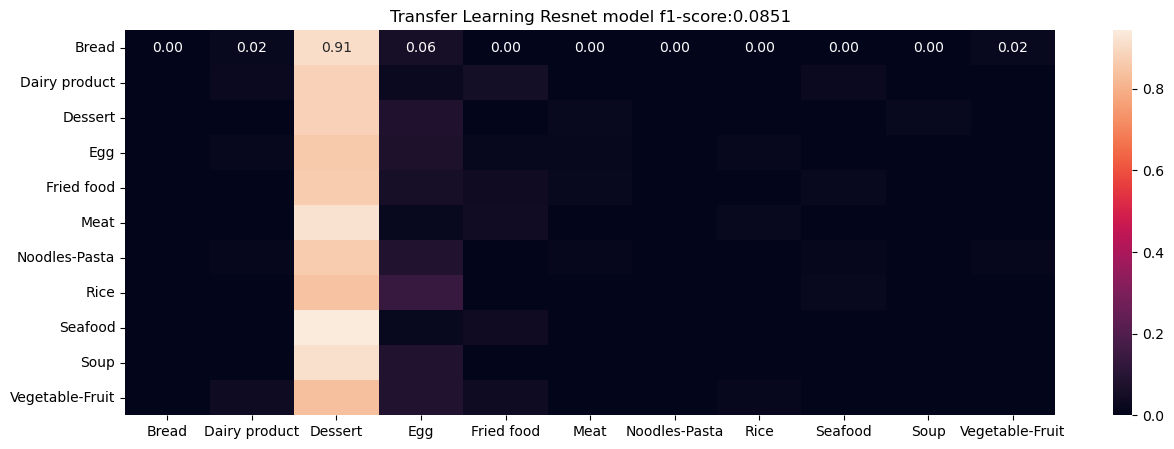

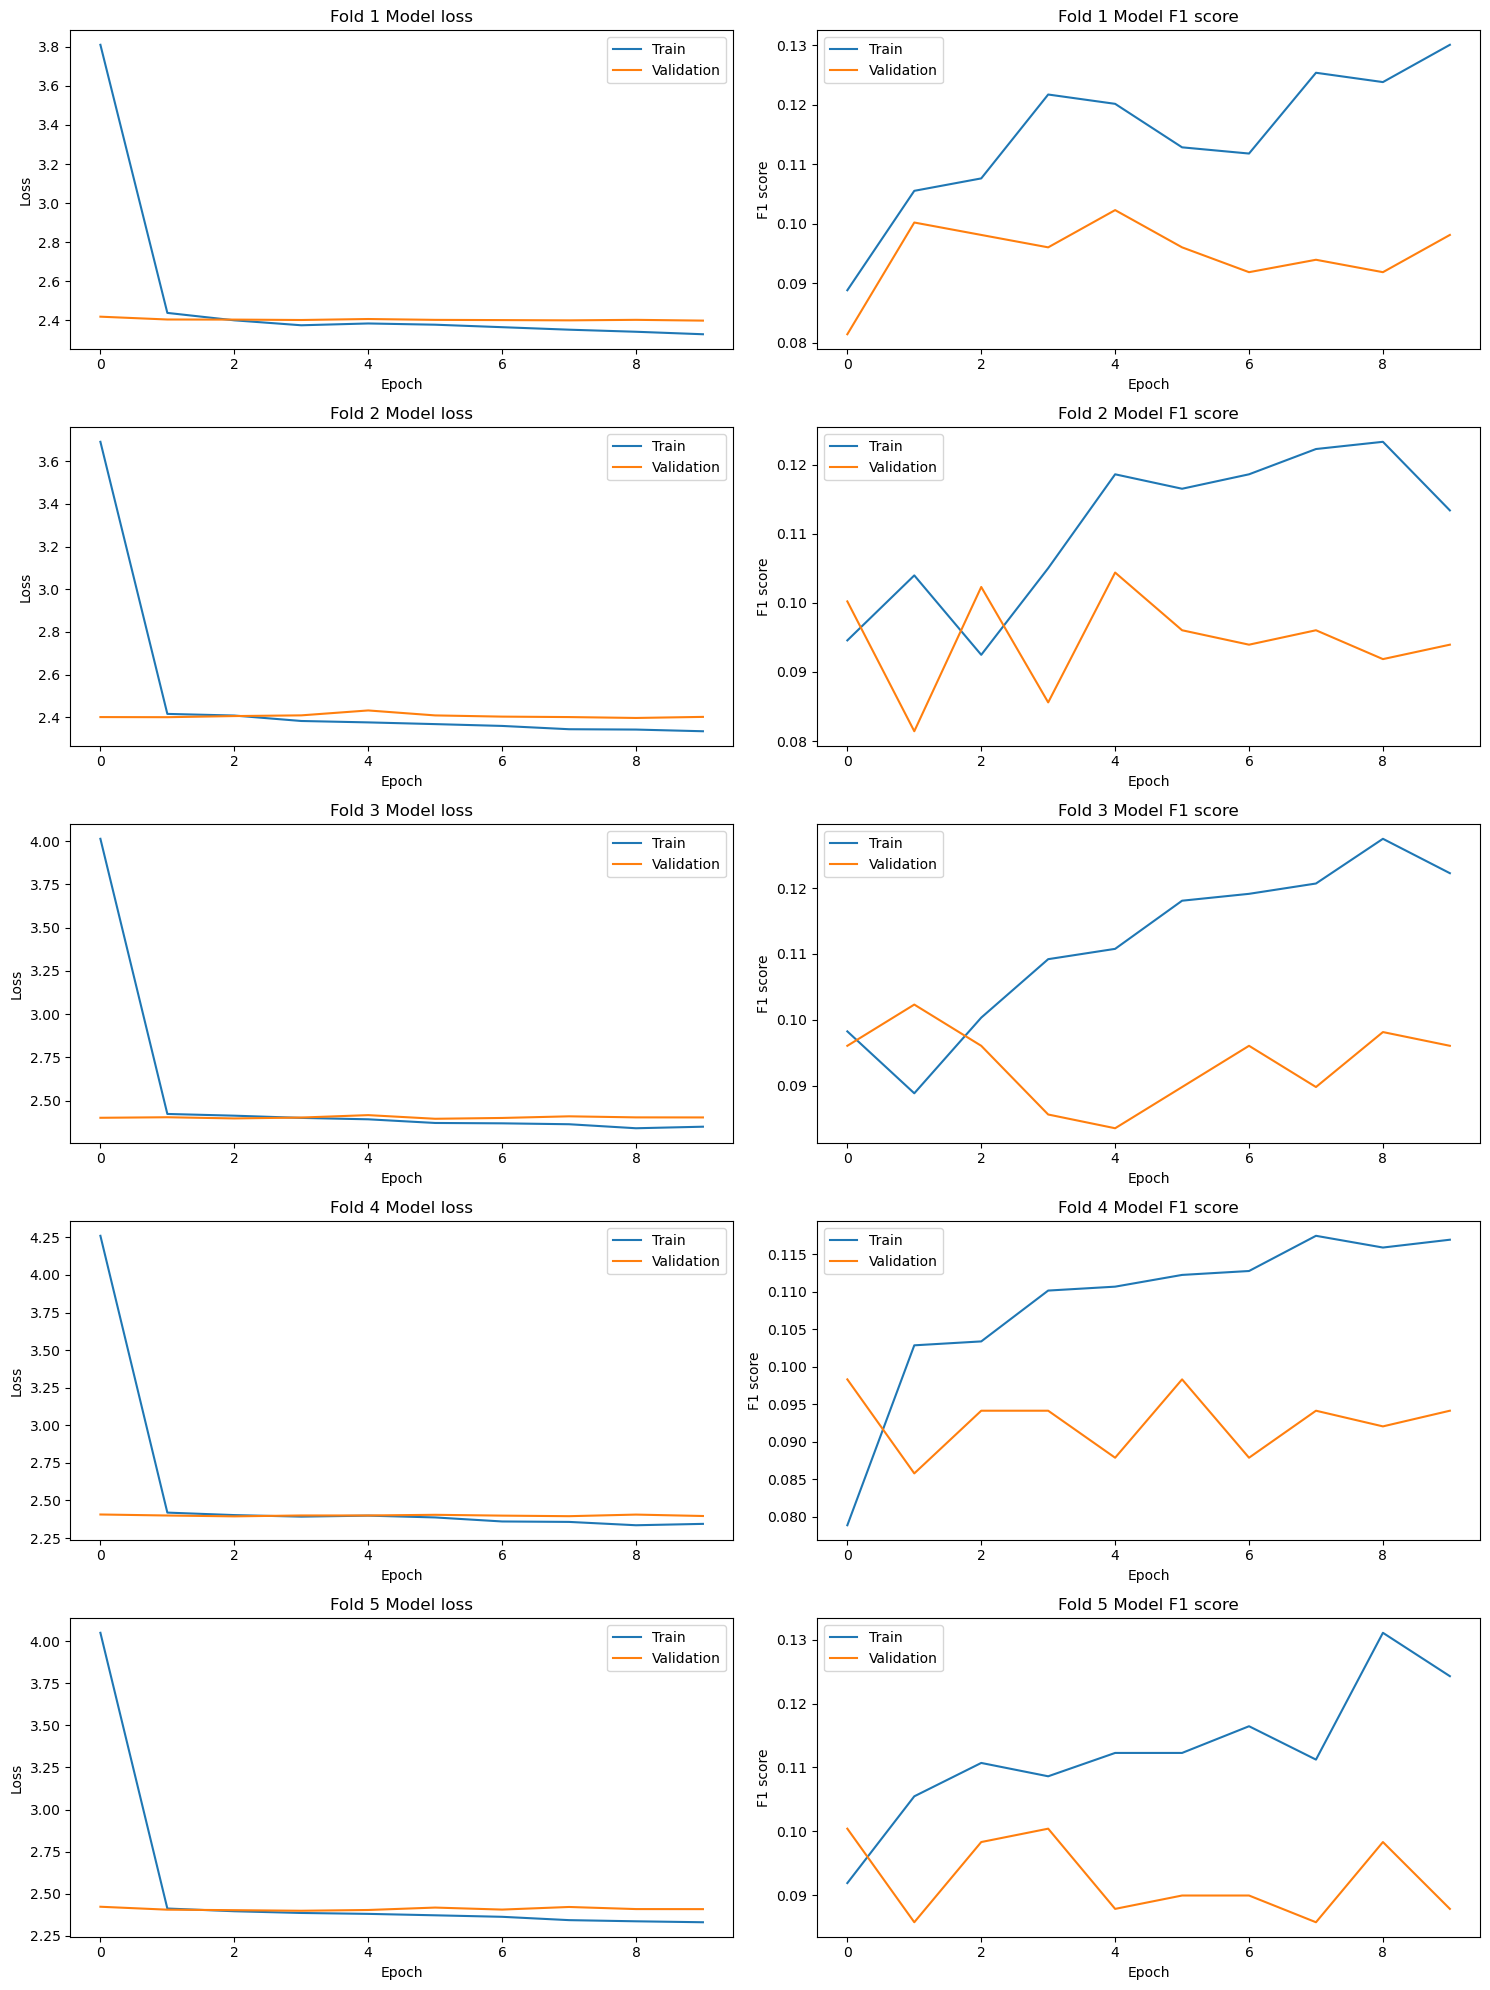

In [123]:
n_splits=5
epoch = 10
skf = StratifiedKFold(n_splits=n_splits)
metrics_res = { 'loss': [], 'val_loss': [], 'f1score' :[], 'val_f1score': [],
}


for train_idx, test_idx in skf.split(x_train_resnet, y_train):
    
    x_train_res_fold, x_test_res_fold = x_train_resnet[train_idx], x_train_resnet[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    input_x = Input(shape=x_train_res_fold[0].shape)
    # Dense layers are the same as those from the best performance model
    x = Flatten()(input_x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.50)(x)
    x = Dense(NUM_CLASSES, activation='softmax')(x)

    resnet3 = Model(inputs=input_x,outputs=x)

    
    resnet3.compile(loss='categorical_crossentropy',
                optimizer='adam', 
                metrics=[F1Score(average='micro', name='f1score')])
    
    y_train_fold_ohe = keras.utils.to_categorical(y_train_fold, NUM_CLASSES)
    y_test_fold_ohe = keras.utils.to_categorical(y_test_fold, NUM_CLASSES)
    
    y_train_fold_ohe_resnet = y_train_fold_ohe[:x_train_resnet.shape[0]]
    
    history_res = resnet3.fit(x_train_res_fold, y_train_fold_ohe_resnet, batch_size=32,epochs=epoch, verbose=2, validation_data=(x_test_res_fold,y_test_fold_ohe[:x_test_res_fold.shape[0]]))
    for key in metrics_res.keys():
        metrics_res[key].extend(history_res.history[key])
    
print(resnet3.summary())
summarize_net(resnet3, x_test_resnet, y_test[:x_test_resnet.shape[0]], "Transfer Learning Resnet model f1-score:")
plot_history(metrics_res, n_splits, epoch)

Transfer Learning perform significantly more poorly(0.0851) in terms of f1-score then the best model(model4: 0.2721).<br> 
Dense layers consist of the same number of units, the same dropout rates, and the same activation functions to compare the two models fairly.<br>


In [124]:
resnet3_val_score = history_res.history['val_f1score']
model4_val_score = history4.history['val_f1score']
print("resnet3 vs. model4(resnet2): ", confidence_interval(resnet3_val_score, model4_val_score))

resnet3 vs. model4(resnet2):  (0.03687295628862481, 0.12086763666791817)


The significance testing shows that model4(resnet2) performs statistically better than resnet3 with transfer learning.<br>
The 95% confidence interval does not include 0, and the entire range being positive indicates that model 4 has better performance in this classification task

# Reference

Keggle, Food-11 image dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset